In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time

import healpy as hp
import pandas as pd
from sklearn.neighbors import KDTree

In [2]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

## Read in data

In [3]:
tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
print('Total number of Gaia quasars:', len(tab_gaia))

Total number of Gaia quasars: 6649162


In [4]:
tab_gaia.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','astrometric_excess_noise','visibility_periods_used','ipd_frac_multi_peak','ruwe','phot_g_n_obs','phot_g_mean_flux','phot_g_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_rp_excess_factor','in_qso_candidates','gaia_crf_source','vari_best_class_name','vari_best_class_score','fractional_variability_g','qso_variability','non_qso_variability','vari_agn_membership_score','classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classlabel_dsc','classlabel_dsc_joint','classlabel_oa','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','n_transits','intensity_quasar','intensity_quasar_error','host_galaxy_detected','intensity_hostgalaxy','intensity_hostgalaxy_error','radius_hostgalaxy','radius_hostgalaxy_error','host_galaxy_flag','source_selection_flags','allwise_oid','designation','w1mpro','w2mpro','

In [5]:
tab_sdss = Table.read('../data/SDSS_DR16Q_v4.fits', format='fits') 
print('Total number of SDSS quasars:', len(tab_sdss))

Total number of SDSS quasars: 750414


In [6]:
tab_sdss.columns

<TableColumns names=('SDSS_NAME','RA','DEC','PLATE','MJD','FIBERID','AUTOCLASS_PQN','AUTOCLASS_DR14Q','IS_QSO_QN','Z_QN','RANDOM_SELECT','Z_10K','Z_CONF_10K','PIPE_CORR_10K','IS_QSO_10K','THING_ID','Z_VI','Z_CONF','CLASS_PERSON','Z_DR12Q','IS_QSO_DR12Q','Z_DR7Q_SCH','IS_QSO_DR7Q','Z_DR6Q_HW','Z_DR7Q_HW','IS_QSO_FINAL','Z','SOURCE_Z','Z_PIPE','ZWARNING','OBJID','Z_PCA','ZWARN_PCA','DELTACHI2_PCA','Z_HALPHA','ZWARN_HALPHA','DELTACHI2_HALPHA','Z_HBETA','ZWARN_HBETA','DELTACHI2_HBETA','Z_MGII','ZWARN_MGII','DELTACHI2_MGII','Z_CIII','ZWARN_CIII','DELTACHI2_CIII','Z_CIV','ZWARN_CIV','DELTACHI2_CIV','Z_LYA','ZWARN_LYA','DELTACHI2_LYA','Z_LYAWG','Z_DLA','NHI_DLA','CONF_DLA','BAL_PROB','BI_CIV','ERR_BI_CIV','AI_CIV','ERR_AI_CIV','BI_SIIV','ERR_BI_SIIV','AI_SIIV','ERR_AI_SIIV','BOSS_TARGET1','EBOSS_TARGET0','EBOSS_TARGET1','EBOSS_TARGET2','ANCILLARY_TARGET1','ANCILLARY_TARGET2','NSPEC_SDSS','NSPEC_BOSS','NSPEC','PLATE_DUPLICATE','MJD_DUPLICATE','FIBERID_DUPLICATE','SPECTRO_DUPLICATE','SKYVERSION

Include only SDSS quasars with z>0.01 (this removes zeros and nans, and maybe a few others)

In [7]:
z_min = 0.01
idx_sdssgood = tab_sdss['Z'] > z_min
tab_sdss = tab_sdss[idx_sdssgood]
print(f'Number of SDSS quasars with: z > {z_min}: {len(tab_sdss)}')

Number of SDSS quasars with: z > 0.01: 750397


Cross-match SDSS and Gaia

In [8]:
coords_sdss = SkyCoord(ra=tab_sdss['RA']*u.degree, dec=tab_sdss['DEC']*u.degree, frame='icrs')    
coords_gaia = SkyCoord(ra=tab_gaia['ra'], dec=tab_gaia['dec'], frame='icrs') 
cross_sdss_gaia = coords_gaia.search_around_sky(coords_sdss, 1*u.arcsec) # Hogg thinks this is idiotic

Make new table, tab_xmatch, with only gaia objects with SDSS match

In [9]:
tab_xmatch = tab_gaia[cross_sdss_gaia[1]]
tab_sdss = tab_sdss[cross_sdss_gaia[0]]
print(f'Number of Gaia quasars with SDSS match (with z min cut): {len(tab_xmatch)}')

Number of Gaia quasars with SDSS match (with z min cut): 407236


In [10]:
tab_xmatch.add_column(tab_sdss['Z'], name='redshift_sdss')

## Dust map

Load in Schlegel, Finkbeiner & Davis (1998) dust map from the dustmaps package

In [11]:
# only do this the first time!
fetch_map = False
if fetch_map:
    from dustmaps.config import config
    config['data_dir'] = '/Users/ksf/code/nyu/research/gaia-quasars-lss/data/dustmaps'

    import dustmaps
    import dustmaps.sfd
    dustmaps.sfd.fetch()

In [12]:
from dustmaps.sfd import SFDQuery
sfd = SFDQuery()

Get reddening E(B-V) from dust map at each of the cross-matched quasars:

E(B-V): https://astronomy.swin.edu.au/cosmos/i/interstellar+reddening

In [13]:
coords = SkyCoord(ra=tab_xmatch['ra'], dec=tab_xmatch['dec'], frame='icrs') 

In [14]:
ebv = sfd(coords)

In [15]:
tab_xmatch.add_column(ebv, name='ebv')

Text(0, 0.5, 'number per bin')

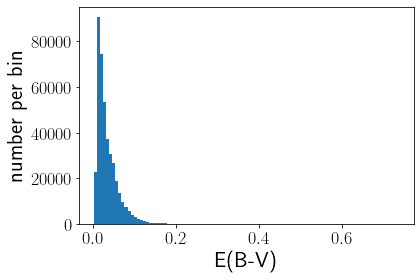

In [16]:
plt.hist(ebv, bins=100)
plt.xlabel('E(B-V)')
plt.ylabel('number per bin')

Plot extinction for SDSS matched quasars:

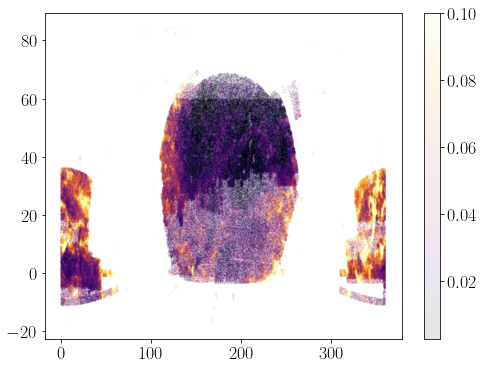

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(tab_xmatch['ra'], tab_xmatch['dec'], c=ebv, s=0.1, alpha=0.1, cmap='inferno', vmax=0.1)
plt.colorbar()

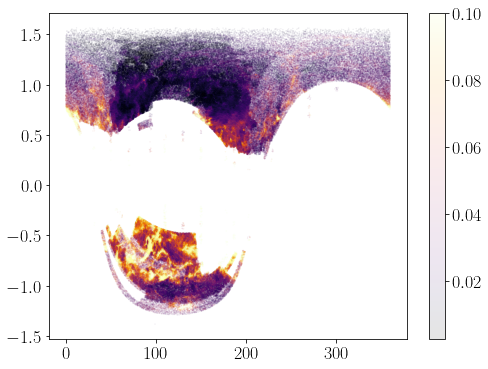

In [18]:
plt.figure(figsize=(8,6))
b = tab_xmatch["b"] * np.pi/180
plt.scatter(tab_xmatch['l'], b, c=ebv, s=0.1, alpha=0.1, cmap='inferno', vmax=0.1)
plt.colorbar()

Get extinction for full Gaia sample (will be used for application of method):

In [19]:
ebv_gaia = sfd(coords_gaia)

In [20]:
tab_gaia.add_column(ebv_gaia, name='ebv')

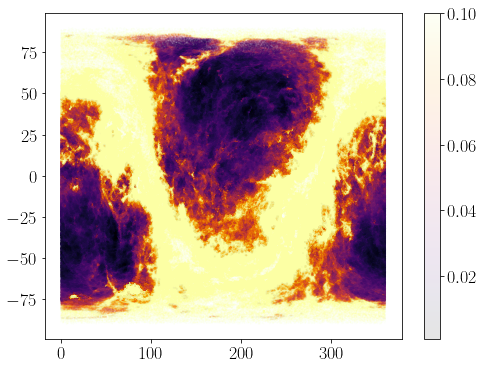

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(tab_gaia['ra'], tab_gaia['dec'], c=ebv_gaia, s=0.1, alpha=0.1, cmap='inferno', vmax=0.1)
plt.colorbar()

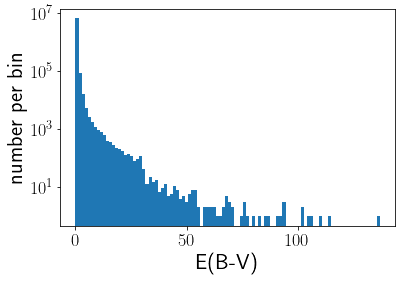

In [22]:
plt.hist(ebv_gaia, bins=100)
plt.xlabel('E(B-V)')
plt.ylabel('number per bin')
plt.yscale('log')

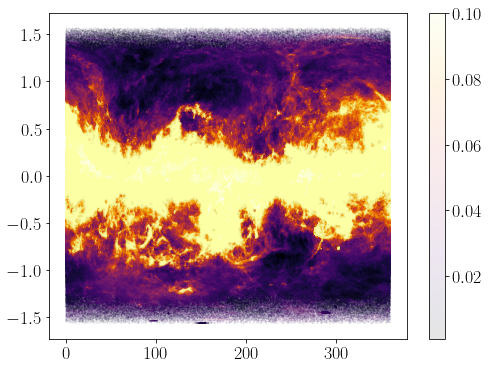

In [23]:
plt.figure(figsize=(8,6))
b = tab_gaia["b"] * np.pi/180
plt.scatter(tab_gaia['l'], b, c=ebv_gaia, s=0.1, alpha=0.1, cmap='inferno', vmax=0.1)
plt.colorbar()

## Color features

Colors, all Gaia:

In [24]:
# ALL GAIA
# wise
w1_w2_gaia = np.array(tab_gaia['w1mpro']) - np.array(tab_gaia['w2mpro'])
g_w1_gaia = np.array(tab_gaia['phot_g_mean_mag']) - np.array(tab_gaia['w1mpro']) # think was error before, w2 instead of w1

Colors, cross-match:

In [25]:
# SDSS cross-match
# gaia
bp_g = np.array(tab_xmatch['phot_bp_mean_mag'] - tab_xmatch['phot_g_mean_mag'])
g_rp = np.array(tab_xmatch['phot_g_mean_mag']) - np.array(tab_xmatch['phot_rp_mean_mag'])
bp_rp = np.array(tab_xmatch['phot_bp_mean_mag']) - np.array(tab_xmatch['phot_rp_mean_mag'])

# wise
w1_w2 = np.array(tab_xmatch['w1mpro']) - np.array(tab_xmatch['w2mpro'])
g_w1 = np.array(tab_xmatch['phot_g_mean_mag']) - np.array(tab_xmatch['w1mpro']) # think was error before, w2 instead of w1

Band values, cross-match:

In [26]:
# SDSS cross-match
# gaia
g = np.array(tab_xmatch['phot_bp_mean_mag'])
rp = np.array(tab_xmatch['phot_rp_mean_mag'])
bp = np.array(tab_xmatch['phot_bp_mean_mag'])

# wise
w1 = np.array(tab_xmatch['w1mpro'])
w2 = np.array(tab_xmatch['w2mpro'])

Check out color space of quasars, & choose cuts to isolate them:

In [140]:
# TODO: better cuts! 
cut_0 = 0., 1., 0.2
cut_1 = 1., 1., 2.9

def plot_cut(ax, cut):

    xx = np.array(ax.get_xlim())
    yy = np.array(ax.get_ylim())

    if abs(cut[0]) > abs(cut[1]):
        ax.plot((cut[2] - cut[1]*yy)/cut[0], yy, 'k-')
    else:
        ax.plot(xx, (cut[2] - cut[0]*xx)/cut[1], 'k-')
        
    ax.set_xlim(xx)
    ax.set_ylim(yy)

def cut_index(g_w1, w1_w2, cut):
    return cut[0] * g_w1 + cut[1] * w1_w2 > cut[2]

Text(0, 0.5, 'W1-W2')

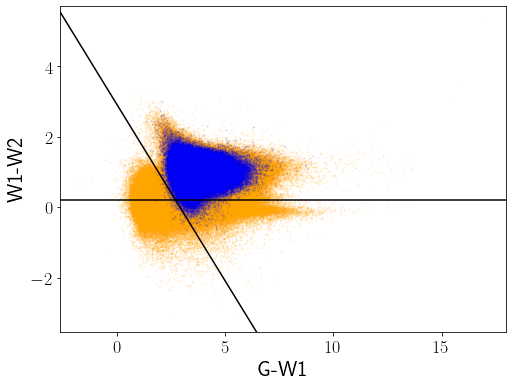

In [141]:
plt.figure(figsize=(8,6))
plt.scatter(g_w1_gaia, w1_w2_gaia, s=1, alpha=0.1, color='orange')
plt.scatter(g_w1, w1_w2, s=1, alpha=0.1, color='blue')

ax = plt.gca()
plot_cut(ax, cut_0)
plot_cut(ax, cut_1)

#plt.axhline(w1_w2_min,color='k')
#plt.axvline(g_w1_min,color='k')

plt.xlim()

plt.xlabel('G-W1')
plt.ylabel('W1-W2')

In [283]:
len(g_w1)

407236

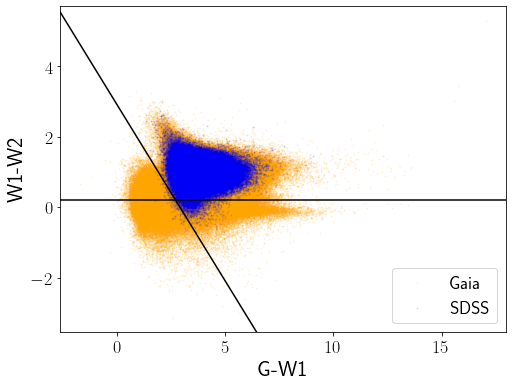

In [285]:
plt.figure(figsize=(8,6))
plt.scatter(g_w1_gaia, w1_w2_gaia, s=1, alpha=0.1, color='orange', label='Gaia')
plt.scatter(g_w1, w1_w2, s=1, alpha=0.1, color='blue', label='SDSS')

ax = plt.gca()
plot_cut(ax, cut_0)
plot_cut(ax, cut_1)

#plt.axhline(w1_w2_min,color='k')
#plt.axvline(g_w1_min,color='k')

plt.xlim()

plt.xlabel('G-W1')
plt.ylabel('W1-W2')
plt.legend()

In [168]:
idx_color = cut_index(g_w1, w1_w2, cut_0) & cut_index(g_w1, w1_w2, cut_1)
print('Fraction of SDSS quasars that make color cuts:', np.sum(idx_color) / np.sum(np.isfinite(w1_w2)))

Fraction of SDSS quasars that make color cuts: 0.9936219048362965


Color cut + magnitude cut

In [169]:
gmag_max = 20
idx_gmag = (tab_xmatch['phot_g_mean_mag'] < gmag_max)
idx_photoz = idx_color & idx_gmag                  
print('Fraction of Gaia-SDSS cross-matched quasars that make cuts:', np.sum(idx_photoz)/len(tab_xmatch))

Fraction of Gaia-SDSS cross-matched quasars that make cuts: 0.41729856888880157


## Features

In [170]:
def construct_X(table, features='colors', rescale_X=False, return_idx_good=False):
    assert features in ['colors', 'magnitudes'], "Feature mode not recognized!"
    
    redshift_qsoc = np.array(table['redshift_qsoc'])
    ebv = np.array(table['ebv'])    
    
    g = np.array(table['phot_g_mean_mag'])
    rp = np.array(table['phot_rp_mean_mag'])
    bp = np.array(table['phot_bp_mean_mag'])

    # wise
    w1 = np.array(table['w1mpro'])
    w2 = np.array(table['w2mpro'])

    if features=='colors':
        X = np.vstack([redshift_qsoc, ebv,
                   bp-g, g-rp, bp-rp, w1-w2, g-w1, 
                   ]).T

    if features=='magnitudes':
        X = np.vstack([redshift_qsoc, ebv,
                   g, bp, rp, w1, w2, 
                   ]).T
    
    idx_good = np.all(np.isfinite(X), axis=1)
    X = X[idx_good]

    # my attempts at rescaling make it worse!! why??
    if rescale_X:
        stds = np.std(X[:,1:], axis=0)
        print(stds)
        X[:,1:] /= stds
    
    print(np.std(X, axis=0))
    print(X.shape)
    if return_idx_good:
        return X, idx_good
    
    return X

In [171]:
def construct_Y(table, idx_to_use=None):
    Y = table['redshift_sdss']
    if idx_to_use is not None:
        Y = Y[idx_to_use]
    print(Y.shape)
    return Y

In [172]:
X, idx_good = construct_X(tab_xmatch[idx_photoz], features='colors', return_idx_good=True, rescale_X=False)
Y = construct_Y(tab_xmatch[idx_photoz], idx_to_use=idx_good)
assert X.shape[0]==Y.shape[0], 'X and Y must have same number of objects!'

[1.0041135  0.02539714 0.12597318 0.16483543 0.20223969 0.22753946
 0.63575789]
(168068, 7)
(168068,)


## Perform cross-validation

Set up samples (loo = leave one out)

In [173]:
n_samples = 8
np.random.seed(17)
i_samples = np.arange(n_samples)
loo_samples = np.random.choice(i_samples, replace=True, size=X.shape[0])

For now, just choosing one of the samples

In [174]:
# guessing 11 for now - hogg's intuition
K = 11

In [175]:
redshift_qsoc_photoz = tab_xmatch['redshift_qsoc'][idx_photoz]

In [176]:
z_err_close = 0.2
frac_recovered_baseline = np.sum(np.abs(Y - redshift_qsoc_photoz[idx_good]) < z_err_close) / len(Y)
print(rf"Fraction of QSOC redshifts with dz < {z_err_close}: {frac_recovered_baseline:.3f}")

Fraction of QSOC redshifts with dz < 0.2: 0.823


In [177]:
Y_hat = np.empty(X.shape[0])
sigma_z = np.empty(X.shape[0])

for i_sample in i_samples:
    print(f"Querying loo_sample={i_sample}")
    idx_train = loo_samples != i_sample
    idx_valid = loo_samples == i_sample
    X_train, Y_train = X[idx_train], Y[idx_train]
    X_valid, Y_valid = X[idx_valid], Y[idx_valid]
    
    # construct tree
    tree = KDTree(X_train)
    
    # query neighbors
    dists, inds = tree.query(X_valid, k=K)
    
    # Choose our best photoz estimate to be the median SDSS (training) redshift 
    # of the nearest neighbors; also get lower and upper percentiles
    low_z_valid, Y_hat_valid, up_z_valid = np.percentile(Y_train[inds], (2.5, 50, 97.5), axis=1)
    sigma_z_valid = (up_z_valid - low_z_valid)/4
    
    Y_hat[idx_valid] = Y_hat_valid
    sigma_z[idx_valid] = sigma_z_valid
    
    frac_recovered = np.sum(np.abs(Y_valid - Y_hat_valid) < z_err_close) / len(Y_valid)
    print(rf"Fraction of photozs with dz < {z_err_close}: {frac_recovered:.3f}")

Querying loo_sample=0
Fraction of photozs with dz < 0.2: 0.907
Querying loo_sample=1
Fraction of photozs with dz < 0.2: 0.905
Querying loo_sample=2
Fraction of photozs with dz < 0.2: 0.902
Querying loo_sample=3
Fraction of photozs with dz < 0.2: 0.906
Querying loo_sample=4
Fraction of photozs with dz < 0.2: 0.902
Querying loo_sample=5
Fraction of photozs with dz < 0.2: 0.903
Querying loo_sample=6
Fraction of photozs with dz < 0.2: 0.908
Querying loo_sample=7
Fraction of photozs with dz < 0.2: 0.904


Plot results

Text(0, 0.5, 'Number per bin')

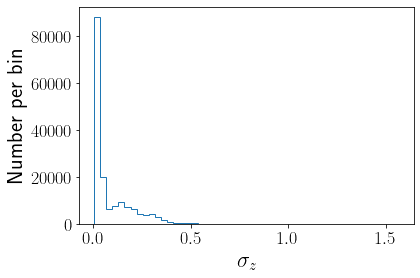

In [178]:
plt.hist(sigma_z, histtype='step', bins=50)
plt.xlabel(r'$\sigma_z$')
plt.ylabel(r'Number per bin')

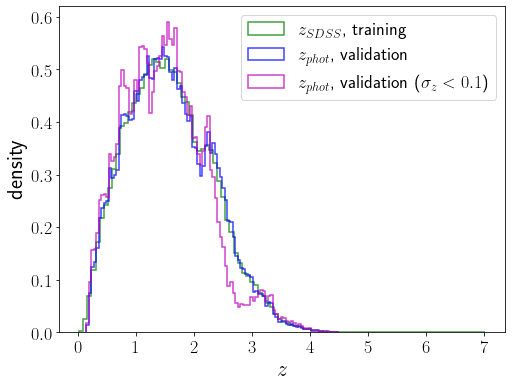

In [179]:
alpha = 0.75
lw = 1.5
density = True
histtype='step'

plt.figure(figsize=(8,6))
_ = plt.hist(Y_train, bins=100, alpha=alpha, color='g', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$, training')
_ = plt.hist(Y_hat, bins=100, alpha=alpha, color='b', lw=lw,
             density=density, histtype=histtype, label=r'$z_{phot}$, validation')
_ = plt.hist(Y_hat[sigma_z < 0.1], bins=100, alpha=alpha, color='m', lw=lw, 
             density=density, histtype=histtype, label=r'$z_{phot}$, validation ($\sigma_z < 0.1$)')
plt.xlabel(r'$z$')
plt.ylabel('density')
plt.legend()

Text(0, 0.5, 'Gaia QSOC redshift')

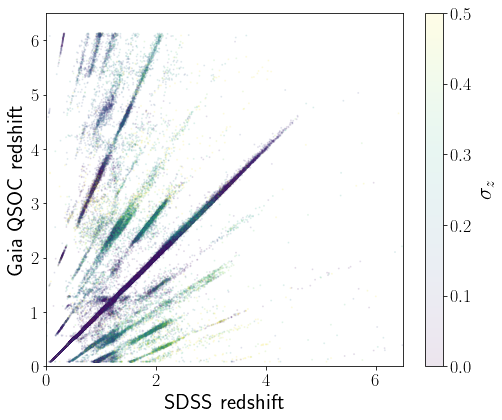

In [180]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
sc = ax.scatter(Y, redshift_qsoc_photoz[idx_good], s = 1, c=sigma_z, vmin=0, vmax=0.5, alpha=0.1)
cbar = plt.colorbar(sc, label=r'$\sigma_z$')
ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)
plt.xlabel('SDSS redshift')
plt.ylabel('Gaia QSOC redshift')

TODO check z-uncertainty vs BAO

Text(0, 0.5, 'redshift estimate (Gaia QSOC + photometry + SFD)')

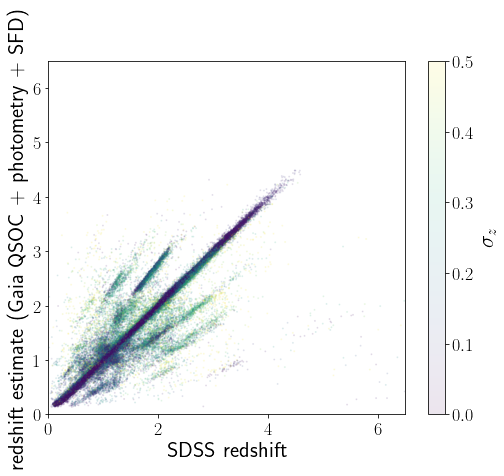

In [181]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
sc = ax.scatter(Y, Y_hat, s = 1, c=sigma_z, vmin=0, vmax=0.5, alpha=0.1)
cbar = plt.colorbar(sc, label=r'$\sigma_z$')
ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)
plt.xlabel('SDSS redshift')
plt.ylabel('redshift estimate (Gaia QSOC + photometry + SFD)')

Text(0, 0.5, 'redshift estimate (Gaia QSOC + photometry + SFD)')

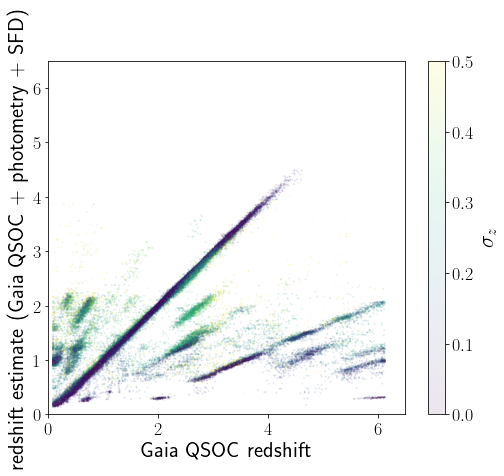

In [182]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
sc = ax.scatter(redshift_qsoc_photoz[idx_good], Y_hat, s = 1, c=sigma_z, vmin=0, vmax=0.5, alpha=0.1)
cbar = plt.colorbar(sc, label=r'$\sigma_z$')
ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)
plt.xlabel('Gaia QSOC redshift')
plt.ylabel('redshift estimate (Gaia QSOC + photometry + SFD)')

Check metrics

In [183]:
z_err_close = 0.2
frac_recovered_baseline = np.sum(np.abs(Y - redshift_qsoc_photoz[idx_good]) < z_err_close) / len(Y)
frac_recovered = np.sum(np.abs(Y - Y_hat) < z_err_close) / len(Y)
print(frac_recovered_baseline)
print(frac_recovered)

0.8225242163886046
0.9046040888211915


In [184]:
percentile_vals = [50, 80, 90, 95, 98]
percentiles = np.percentile(np.abs(Y - Y_hat), percentile_vals)
print(f'The {percentile_vals} percentiles of redshift errors are:')
print([float(f"{p:.3f}") for p in percentiles])

The [50, 80, 90, 95, 98] percentiles of redshift errors are:
[0.018, 0.049, 0.174, 0.574, 0.859]


Text(0, 0.5, 'number per bin')

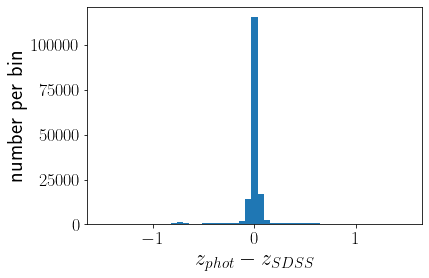

In [185]:
bins = np.linspace(-1.5, 1.5, 50)
plt.hist(Y - Y_hat, bins=bins)
plt.xlabel(r'$z_{phot} - z_{SDSS}$')
plt.ylabel('number per bin')

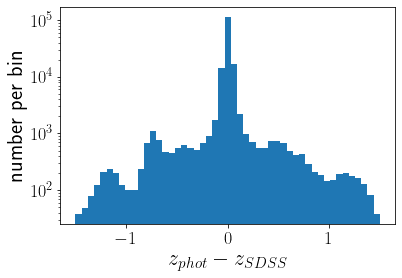

In [186]:
bins = np.linspace(-1.5, 1.5, 50)
plt.hist(Y - Y_hat, bins=bins)
plt.xlabel(r'$z_{phot} - z_{SDSS}$')
plt.ylabel('number per bin')
plt.yscale('log')

# Apply photozs to whole sample

In [187]:
idx_gaia_color = cut_index(g_w1_gaia, w1_w2_gaia, cut_0) & cut_index(g_w1_gaia, w1_w2_gaia, cut_1)

idx_gaia_gmag = (tab_gaia['phot_g_mean_mag'] < gmag_max)  
print(np.sum(idx_gaia_color)/len(tab_gaia))
print(np.sum(idx_gaia_gmag)/len(tab_gaia))

0.2391411128199313
0.27674825790077007


In [188]:
idx_gaia_photoz = idx_gaia_color & idx_gaia_gmag   
print(np.sum(idx_gaia_photoz), len(tab_gaia))

692526 6649162


In [189]:
X_gaia_photoz, idx_good_gaia_photoz = construct_X(tab_gaia[idx_gaia_photoz], features='colors', return_idx_good=True)

[1.0566654  0.08459206 0.15721492 0.2348798  0.22086017 0.23874604
 0.7102286 ]
(648842, 7)


In [256]:
print(np.sum(idx_good_gaia_photoz))

648842


In [190]:
tree = KDTree(X)

In [191]:
dists_gaia_photoz, inds_gaia_photoz = tree.query(X_gaia_photoz, k=K)

In [192]:
low_z_gaia_photoz, Y_hat_gaia_photoz, up_z_gaia_photoz = np.percentile(Y[inds_gaia_photoz], (2.5, 50, 97.5), axis=1)
sigma_z_gaia_photoz = (up_z_gaia_photoz - low_z_gaia_photoz)/4

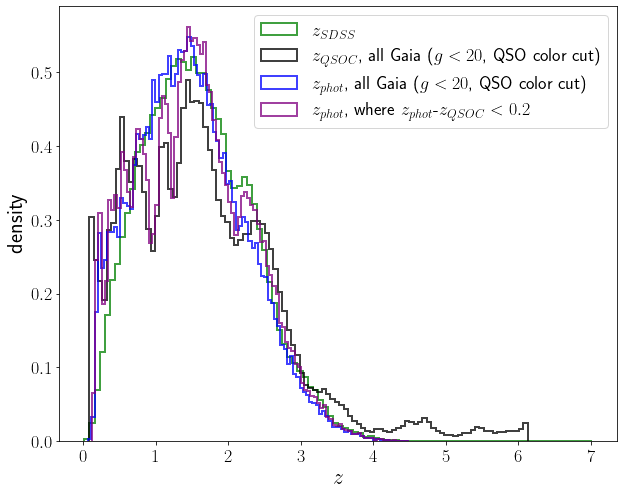

In [193]:
alpha = 0.75
lw = 2
density = True
histtype='step'

# should i take from photoz or qsoc? on same line so v similar
z_err_close = 0.2
Y_agree_gaia_photoz = Y_hat_gaia_photoz[np.abs(Y_hat_gaia_photoz - X_gaia_photoz[:,0]) < z_err_close]

plt.figure(figsize=(10,8))
_ = plt.hist(Y, bins=100, alpha=alpha, color='g', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$')
_ = plt.hist(X_gaia_photoz[:,0], bins=100, alpha=alpha, color='k', lw=lw, 
             density=density, histtype=histtype, label=rf'$z_{{QSOC}}$, all Gaia ($g < {gmag_max}$, QSO color cut)')
_ = plt.hist(Y_hat_gaia_photoz, bins=100, alpha=alpha, color='b', lw=lw, 
             density=density, histtype=histtype, label=rf'$z_{{phot}}$, all Gaia ($g < {gmag_max}$, QSO color cut)')
_ = plt.hist(Y_agree_gaia_photoz, bins=100, alpha=alpha, color='purple', lw=lw, 
             density=density, histtype=histtype, label=rf'$z_{{phot}}$, where $z_{{phot}}$-$z_{{QSOC}} < {z_err_close}$')


plt.xlabel(r'$z$')
plt.ylabel('density')
plt.legend()

# Healpix 

Generate pixels

In [194]:
# healpix grids have npix = 12*nside^2. want n_qso_per_pix=10-20 QS0s per pixel, so if we have n_qso quasars, we want:
# nside = sqrt((n_qso/n_qso_per_pix)/12)
n_qso = len(tab_gaia[idx_gaia_photoz])
n_qso_per_pix = 15
NSIDE = round(np.sqrt((n_qso/n_qso_per_pix)/12))
print(NSIDE)

62


In [195]:
print("Approximate resolution at NSIDE {} is {:.2} deg".format(NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60))

Approximate resolution at NSIDE 62 is 0.95 deg


In [196]:
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.894 deg


In [197]:
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

46128


In [198]:
pixel_arr = np.arange(NPIX)

Apply to data

In [199]:
pixel_indices = hp.ang2pix(NSIDE, tab_gaia['ra'][idx_gaia_photoz], tab_gaia['dec'][idx_gaia_photoz], lonlat=True)

In [200]:
R_v = 3.1
av_gaia_photoz = R_v * tab_gaia['ebv'][idx_gaia_photoz]
len(av_gaia_photoz)

692526

In [201]:
# copied from https://stackoverflow.com/questions/49372918/group-numpy-into-multiple-sub-arrays-using-an-array-of-values
def groupby(values, group_indices):
    # Get argsort indices, to be used to sort a and b in the next steps
    sidx = group_indices.argsort(kind='mergesort')
    values_sorted = values[sidx]
    group_indices_sorted = group_indices[sidx]

    # Get the group limit indices (start, stop of groups)
    cut_idx = np.flatnonzero(np.r_[True,group_indices_sorted[1:] != group_indices_sorted[:-1],True])

    # Split input array with those start, stop ones
    values_grouped = [values_sorted[i:j] for i,j in zip(cut_idx[:-1],cut_idx[1:])]
    return values_grouped, list(set(group_indices_sorted))

In [202]:
# this is too slow, use groupby
# av_mean = [np.mean(av_gaia_gmag[np.where(pixel_idx == pixel_indices)]) for pixel_idx in pixel_indices]
av_grouped, pixel_indices_sorted = groupby(av_gaia_photoz, pixel_indices)

Check number per pixel

In [203]:
n_per_pixel = np.array([len(avs) for avs in av_grouped])

Text(0, 0.5, 'number per (histogram) bin')

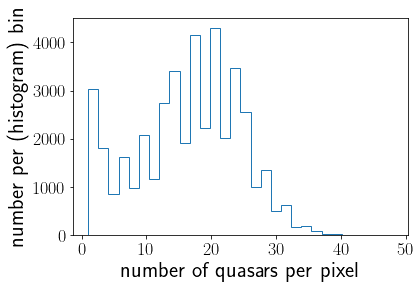

In [204]:
plt.hist(n_per_pixel, bins=30, histtype='step')
plt.xlabel('number of quasars per pixel')
plt.ylabel('number per (histogram) bin')

In [205]:
av_means = np.array([np.mean(avs) for avs in av_grouped])

In [206]:
map_av = np.zeros(NPIX)
map_av[pixel_indices_sorted] = av_means

In [207]:
pixels_nodata = list(set(pixel_arr) - set(pixel_indices_sorted))
map_av[pixels_nodata] = np.nan

In [208]:
map_nqso = np.zeros(NPIX)
map_nqso[pixel_indices_sorted] = n_per_pixel

0.0 180.0 -180.0 180.0


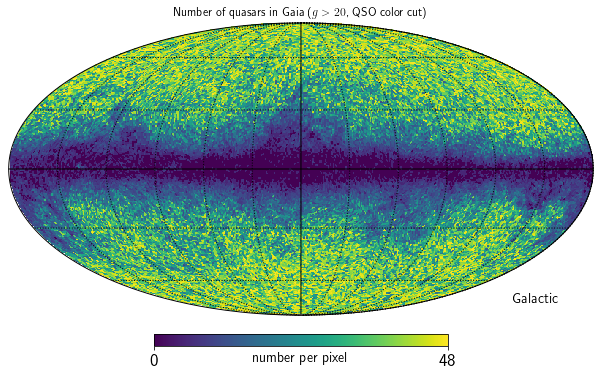

In [209]:
hp.mollview(
    map_nqso,
    title=rf"Number of quasars in Gaia ($g > {gmag_max}$, QSO color cut)",
    unit=r"number per pixel",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

In [210]:
area_per_pixel

0.8943149767910873

0.0 180.0 -180.0 180.0


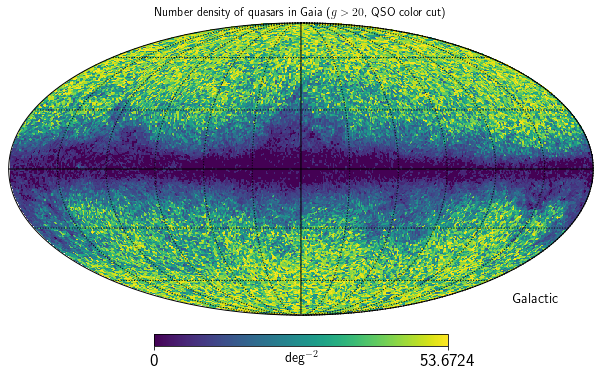

In [211]:
hp.mollview(
    map_nqso/area_per_pixel,
    title=rf"Number density of quasars in Gaia ($g > {gmag_max}$, QSO color cut)",
    unit=r"deg$^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

Random catalog

In [212]:
N_rand = n_qso*10
us = np.random.uniform(size=N_rand)
vs = np.random.uniform(size=N_rand)
theta_rand = 2 * np.pi * us
phi_rand = np.arccos(2*vs-1)

In [213]:
ra_rand = (theta_rand * 180/np.pi) * u.deg
dec_rand = (phi_rand * 180/np.pi - 90) * u.deg

In [214]:
coords_rand = SkyCoord(ra=ra_rand, dec=dec_rand, frame='icrs') 

In [215]:
ebv_rand = sfd(coords_rand)

In [216]:
av_rand = R_v*ebv_rand

In [217]:
pixel_indices_rand = hp.ang2pix(NSIDE, ra_rand.value, dec_rand.value, lonlat=True)

In [218]:
av_grouped_rand, pixel_indices_sorted_rand = groupby(av_rand, pixel_indices_rand)

In [219]:
av_means_rand = np.array([np.mean(avs) for avs in av_grouped_rand])

In [220]:
map_av_rand = np.zeros(hp.nside2npix(NSIDE))
map_av_rand[pixel_indices_sorted_rand] = av_means_rand

0.0 180.0 -180.0 180.0


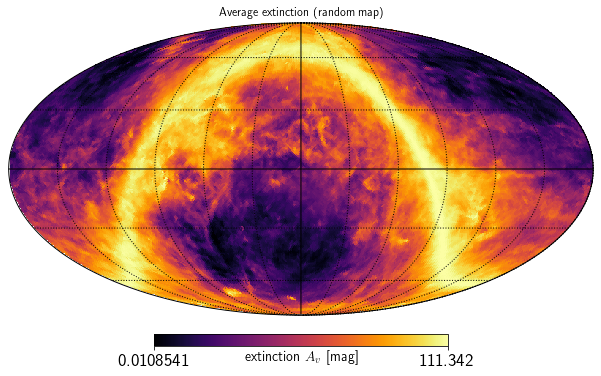

In [221]:
hp.mollview(
    map_av_rand,
    title=r"Average extinction (random map)",
    unit=r"extinction $A_v$ [mag]",
    norm="hist",
    cmap='inferno',
    #min=-1,
    #max=1,
)
hp.graticule()

0.0 180.0 -180.0 180.0


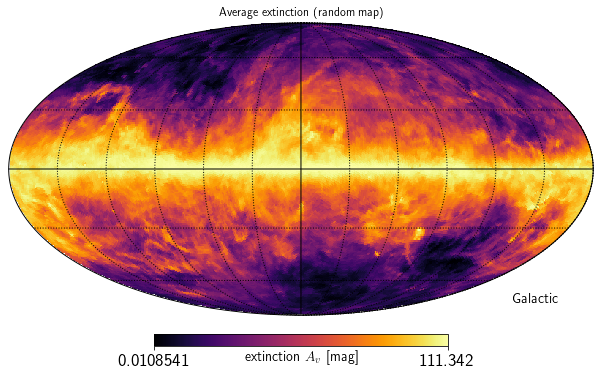

In [222]:
hp.mollview(
    map_av_rand,
    title=r"Average extinction (random map)",
    unit=r"extinction $A_v$ [mag]",
    norm="hist",
    cmap='inferno',
    coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

0.0 180.0 -180.0 180.0


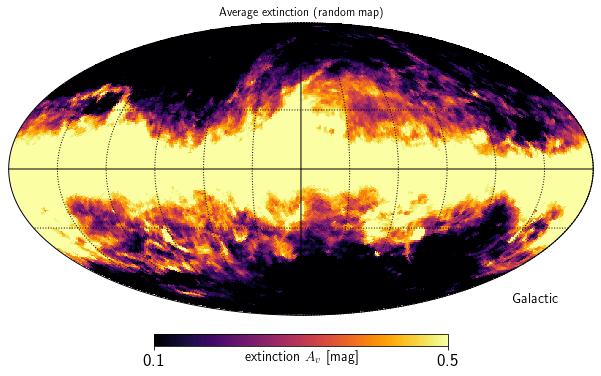

In [223]:
hp.mollview(
    map_av_rand,
    title=r"Average extinction (random map)",
    unit=r"extinction $A_v$ [mag]",
    norm="hist",
    cmap='inferno',
    coord=['C', 'G'],
    min=0.1,
    max=0.5,
)
hp.graticule()

In [224]:
len(n_per_pixel), len(av_means_rand)

(42331, 46128)

Number density of QSOs vs A_v

In [225]:
# area_per_pixel = deg/pix
# n_qso = N/pix
# so n_per_deg = n_qso / area_per_pixel

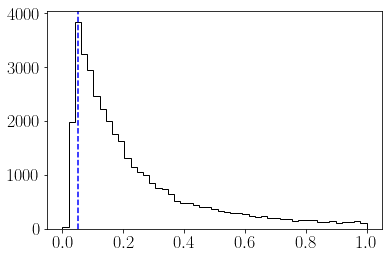

In [226]:
av_bins = np.linspace(0, 1, 50)
plt.hist(map_av_rand, bins=av_bins, histtype='step', color='k')
av0_max = 0.05
plt.axvline(av0_max, color='b', ls='--')

In [227]:
ndens_qso = map_nqso/area_per_pixel
ndens_qso_at_av0 = np.mean(ndens_qso[map_av_rand < av0_max])
print(ndens_qso_at_av0)

26.072551367076784


Text(0, 0.5, 'number density of Gaia QSOs [deg$^{-2}$]')

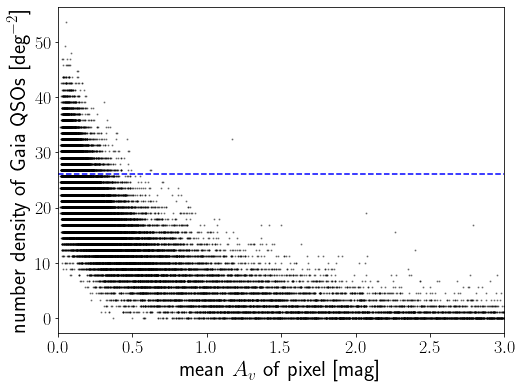

In [228]:
plt.figure(figsize=(8,6))
plt.scatter(map_av_rand, map_nqso/area_per_pixel, color='k', s=1, alpha=0.4)
plt.axhline(ndens_qso_at_av0, label=rf'Average number density of QSOs where $A_v < {av0_max}$', color='b', ls='--')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 3)
plt.xlabel(r'mean $A_v$ of pixel [mag]')
plt.ylabel(r'number density of Gaia QSOs [deg$^{-2}$]')

In [229]:
def prob_Av(A_v, norm): 
    return np.exp(-A_v/norm)

In [230]:
from scipy.optimize import curve_fit
params_initial_guess = [1]
params_best_fit, _ = curve_fit(prob_Av, map_av_rand, ndens_qso/ndens_qso_at_av0, p0=params_initial_guess)
print(params_best_fit)
p_Av = prob_Av(map_av_rand, *params_best_fit)

[0.74457303]


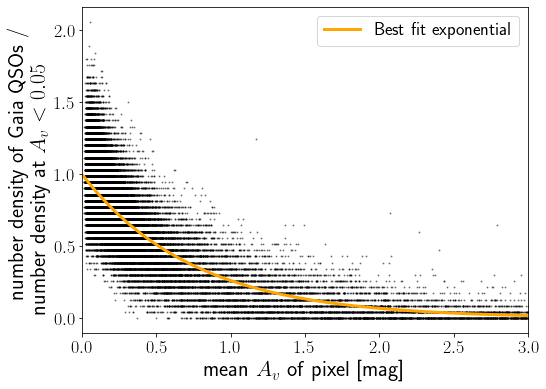

In [231]:
plt.figure(figsize=(8,6))
plt.scatter(map_av_rand, ndens_qso/ndens_qso_at_av0, color='k', s=1, alpha=0.4)
idx_av_sorted = np.argsort(map_av_rand)
plt.plot(map_av_rand[idx_av_sorted], p_Av[idx_av_sorted], color='orange', lw=3, label='Best fit exponential')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 3)
plt.xlabel(r'mean $A_v$ of pixel [mag]')
plt.ylabel(rf'number density of Gaia QSOs / \\ number density at $A_v < {av0_max}$')
plt.legend()

Text(0, 0.5, 'number density of Gaia QSOs [deg$^{-2}$]')

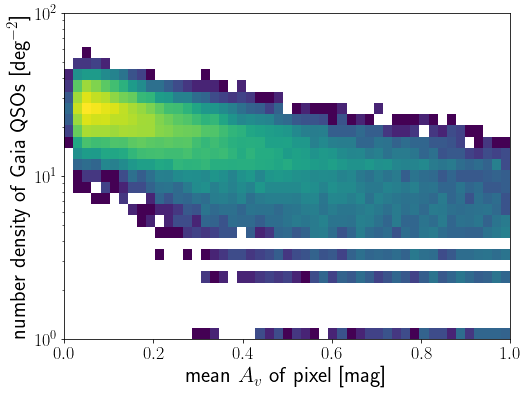

In [232]:
plt.figure(figsize=(8,6))
av_bins = np.linspace(0, 1, 50)
#ndens_bins = np.linspace(0,60,61)
ndens_bins = np.logspace(0,2,30)
plt.hist2d(map_av_rand, ndens_qso, bins=[av_bins, ndens_bins], norm=matplotlib.colors.LogNorm(), )
#plt.xscale('log')
plt.yscale('log')
#plt.xlim(0, 3)
plt.xlabel(r'mean $A_v$ of pixel [mag]')
plt.ylabel(r'number density of Gaia QSOs [deg$^{-2}$]')

overplot log of integrated number density of croom brighter than 20 - Av

In [233]:
# from Croom+2009 (https://watermark.silverchair.com/mnras0399-1755.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAvkwggL1BgkqhkiG9w0BBwagggLmMIIC4gIBADCCAtsGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM0bx1xrurbPjhw291AgEQgIICrA-TaVZLrM45-jMNX82T5C6ZjocrGEuFNjwP4S_dtJCmlUloEb1C8gYOpTCoP-amWMCMjmHLc10G68fr2b5JZbNzwW3pUlfb91KR1Wxj8VMDyNcpBwidgPpaFB27k8s1szlJNRMUwasEv1WJonFrkiXRcRqdfVkhPtdJMrK3WZXIa7qvP61AIvQ0PTytApdL5r4taph4sk7j0OF60tajDssCsye96vBgcxMppZkKSJn4OptOKh4W6rva7ixSYXpyg9sZ6ipwMd3NN1R_7zIYieXeyCrT0W11ObqO8MzHUO4Qkfu31vEro-sL6DC2iZkTmhc6CFTvFJrZtf142_c-2JvUr7em12vxwj9jUZfhMLxkmKAsSTDoOi4_GoJ795JaCWIm61tOoGYzYjamx2I0pMb1dz-5sR578tGCVhqEBFJcQEpBEa6G0IqjzJ8PvtP1Rcb35bmN-iK7lRQgce5GQghdxz7xDyyeRdSfx3kLZmCMbHNbKKRzbcGpsGv4TDcDuxZZq1iLN2jcN58uK8HHLdxkodHpTPQHewwXv0FFrFCTLx9LMNdEQ-RhIDXLNaMwZ_JCy6b3HtvT8S7O0fdMlkNQAO09BrMHPJWMKTN1SsssOGxe23ZLvIsvVRd43LjFgUr1sZxCJgyZEkVIlCuYW1ZwxE6JG35GzRYCMk_gTgZYF7_jVJoBYvIvkIsN90DgUa9i4ZIhHWaGFQypaLbh0FsYoaENxsrXxqQsaEPWfzm1Qs0c4NfNifbmYYXghuDQxJtB9raAjIL_h8AgGn-p5h7uel66sPpCojKmbyrnzFICu3O2R8sQl9R0Ry8a5HhQy6t0TafX9GX7vF9FXzt1fS5QdzjvtsdTx5VAsLunMDKWWorufdPouDP6oRbdSFavJ92OR7ruVuRxHlwdhA)
# using plot digitizer
mags_2slaq, counts_2slaq = np.loadtxt('../data/qso_counts_2SLAQ_croom2009.csv', delimiter=',', unpack=True)

In [234]:
av_bins = np.linspace(0, 1, 50)

In [235]:
# print(mags_2slaq)
# print(counts_2slaq)

In [236]:
idx_mag_in_bins = (mags_2slaq < gmag_max)
integral_big = np.sum(counts_2slaq[idx_mag_in_bins])
integrated_ndens_croom = np.empty(len(av_bins)-1)
integrated_ndens_croom[0] = 1.0 # because at A_v = 0, same integral
for i in range(1,len(av_bins)-1):
    mag = av_bins[i+1]
    idx_mag_in_bins = (mags_2slaq < gmag_max - mag)
    integral_small = np.sum(counts_2slaq[idx_mag_in_bins])
    integrated_ndens_croom[i] = integral_small / integral_big

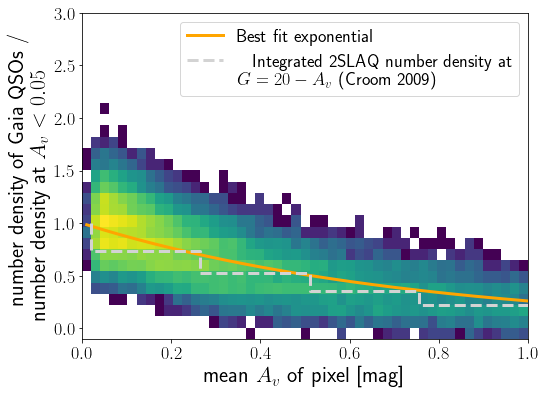

In [237]:
plt.figure(figsize=(8,6))
#ndens_bins = np.linspace(0,60,61)
ndens_bins = np.linspace(-0.1,3,30)
plt.hist2d(map_av_rand, ndens_qso/ndens_qso_at_av0, bins=[av_bins, ndens_bins], norm=matplotlib.colors.LogNorm(), )
plt.plot(map_av_rand[idx_av_sorted], p_Av[idx_av_sorted], color='orange', lw=3, label='Best fit exponential')

plt.step(av_bins[1:], integrated_ndens_croom, color='lightgrey', ls='--', lw=3, 
         label=rf'Integrated 2SLAQ number density at \\$G={gmag_max}-A_v$ (Croom 2009)')

#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0, 3)
plt.xlabel(r'mean $A_v$ of pixel [mag]')
plt.ylabel(rf'number density of Gaia QSOs / \\ number density at $A_v < {av0_max}$')
plt.legend()

Redshift distribution of Gaia quasars in quartiles of mean reddening

In [238]:
redshift_qsoc_gaia_photoz = tab_gaia['redshift_qsoc'][idx_gaia_photoz]

In [239]:
av_rand_gaia_photoz = np.array([map_av_rand[pixel_idx] for pixel_idx in pixel_indices])
len(av_rand_gaia_photoz)

692526

In [240]:
percentile_vals = [0, 25, 50, 75, 100]
percentiles = np.percentile(av_rand_gaia_photoz, percentile_vals)
print(percentiles)

[1.08540980e-02 7.07839057e-02 1.29239932e-01 2.40269795e-01
 6.55512085e+01]


173122
173129
173122
173131


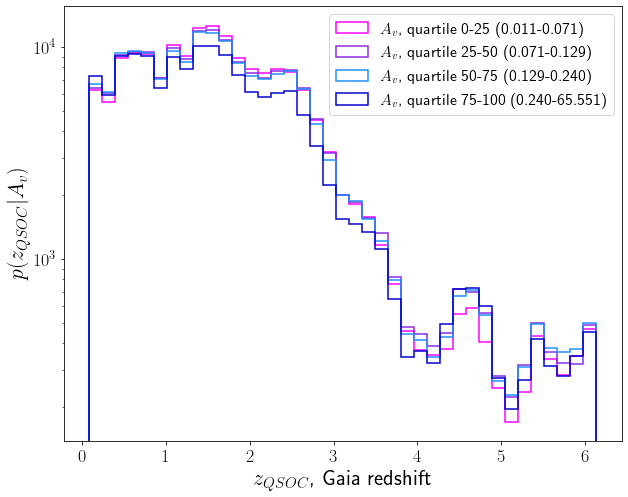

In [241]:
bins = np.linspace(np.min(redshift_qsoc_gaia_photoz), np.max(redshift_qsoc_gaia_photoz), 40)
labels = [rf'$A_v$, quartile {percentile_vals[i]}-{percentile_vals[i+1]}'
          f' ({percentiles[i]:.3f}-{percentiles[i+1]:.3f})' for i in range(len(percentile_vals)-1)]
colors = ['magenta', 'blueviolet', 'dodgerblue', 'mediumblue']

plt.figure(figsize=(10,8))
for i in range(len(percentiles)-1):
    z_with_av_in_bin = redshift_qsoc_gaia_photoz[(av_rand_gaia_photoz > percentiles[i]) &
                                                 (av_rand_gaia_photoz <= percentiles[i+1])]
    print(len(z_with_av_in_bin))
    plt.hist(z_with_av_in_bin, bins=bins, histtype='step', label=labels[i], color=colors[i], lw=1.5)
    
plt.xlabel(r'$z_{QSOC}$, Gaia redshift')
plt.ylabel(r'$p(z_{QSOC}|A_v)$')
plt.legend(fontsize=16)
plt.yscale('log')

For gaia photo-zs, need to redo percentiles because we cut out some QSOs that didn't have WISE colors:

In [242]:
percentile_vals = [0, 25, 50, 75, 100]
percentiles = np.percentile(av_rand_gaia_photoz[idx_good_gaia_photoz], percentile_vals)
print(percentiles)

[1.08540980e-02 6.91306517e-02 1.24104217e-01 2.24337414e-01
 5.56439667e+01]


162195
162223
162201
162201


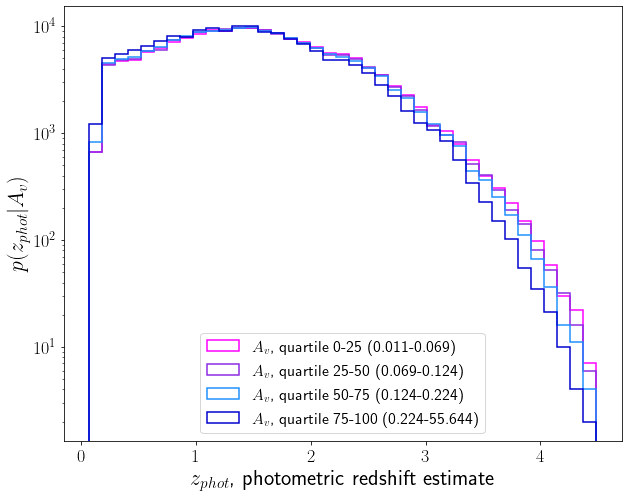

In [243]:
bins = np.linspace(np.min(Y_hat_gaia_photoz), np.max(Y_hat_gaia_photoz), 40)
labels = [rf'$A_v$, quartile {percentile_vals[i]}-{percentile_vals[i+1]}'
          f' ({percentiles[i]:.3f}-{percentiles[i+1]:.3f})' for i in range(len(percentile_vals)-1)]
colors = ['magenta', 'blueviolet', 'dodgerblue', 'mediumblue']

plt.figure(figsize=(10,8))
for i in range(len(percentiles)-1):
    z_with_av_in_bin = Y_hat_gaia_photoz[(av_rand_gaia_photoz[idx_good_gaia_photoz] > percentiles[i]) &
                                         (av_rand_gaia_photoz[idx_good_gaia_photoz] <= percentiles[i+1])]
    print(len(z_with_av_in_bin))
    plt.hist(z_with_av_in_bin, bins=bins, histtype='step', label=labels[i], color=colors[i], lw=1.5)
    
plt.xlabel(r'$z_{phot}$, photometric redshift estimate')
plt.ylabel(r'$p(z_{phot}|A_v)$')
plt.legend(fontsize=16, loc='lower center')
plt.yscale('log')

162195
162223
162201
162201


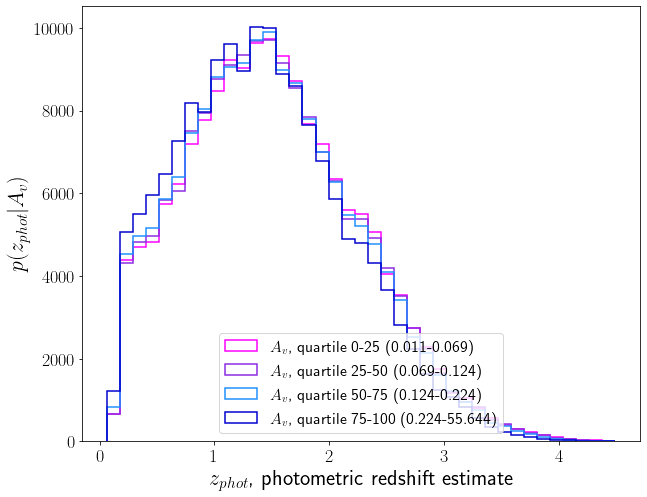

In [244]:
bins = np.linspace(np.min(Y_hat_gaia_photoz), np.max(Y_hat_gaia_photoz), 40)
labels = [rf'$A_v$, quartile {percentile_vals[i]}-{percentile_vals[i+1]}'
          f' ({percentiles[i]:.3f}-{percentiles[i+1]:.3f})' for i in range(len(percentile_vals)-1)]
colors = ['magenta', 'blueviolet', 'dodgerblue', 'mediumblue']

plt.figure(figsize=(10,8))
for i in range(len(percentiles)-1):
    z_with_av_in_bin = Y_hat_gaia_photoz[(av_rand_gaia_photoz[idx_good_gaia_photoz] > percentiles[i]) &
                                         (av_rand_gaia_photoz[idx_good_gaia_photoz] <= percentiles[i+1])]
    print(len(z_with_av_in_bin))
    plt.hist(z_with_av_in_bin, bins=bins, histtype='step', label=labels[i], color=colors[i], lw=1.5)
    
plt.xlabel(r'$z_{phot}$, photometric redshift estimate')
plt.ylabel(r'$p(z_{phot}|A_v)$')
plt.legend(fontsize=16, loc='lower center')
#plt.yscale('log')

cumul dist of quasars as func of extinction; may choose to cut some extinction

TODO could make totally random set of points, and then remove with probability based on function of n_qsos vs A_v; e.g. if we see that as A_v doubles we get 5x fewer quasars, remove with that probability

## Make random sample based on SFD map

In [245]:
def random_ra_dec_on_sphere(N_sphere):
    us = np.random.uniform(size=N_sphere)
    vs = np.random.uniform(size=N_sphere)
    theta_sphere = 2 * np.pi * us
    phi_sphere = np.arccos(2*vs-1)
    
    ra_sphere = theta_sphere * 180/np.pi #+ 180
    dec_sphere = phi_sphere * 180/np.pi - 90
    return ra_sphere, dec_sphere

In [246]:
def generate_random_sfd(N_rand_target, reduction_factor_estimate, norm_best_fit):
    N_sphere = round(N_rand_target/reduction_factor_estimate)
    ra_sphere, dec_sphere = random_ra_dec_on_sphere(N_sphere)

    coords_sphere = SkyCoord(ra=ra_sphere*u.deg, dec=dec_sphere*u.deg, frame='icrs') 
    
    randoms_sphere = np.random.rand(N_sphere)
    
    # doing this from full map right, not averaged?
    ebv_sphere = sfd(coords_sphere)
    av_sphere = R_v*ebv_sphere
    
    p_accept = prob_Av(av_sphere, norm_best_fit)
    
    # if probability is greater than random, keep
    # (if p=1, will always keep; if p=0, almost never)
    keep = p_accept >= randoms_sphere
    return ra_sphere[keep], dec_sphere[keep]

In [247]:
# estimate reduction factor by downsampling based on A_v map
N_rand_start = 100000
reduction_factor_start = 1. # don't reduce so we can deduce the reduction factor
ra_rand, dec_rand = generate_random_sfd(N_rand_start, reduction_factor_start, params_best_fit)
reduction_factor_estimate = len(ra_rand)/N_rand_start
print(reduction_factor_estimate)

0.62444


In [111]:
# now do with actual number of qsos desired, using the reduction factor we found
N_rand_target = np.sum(idx_gaia_photoz)
ra_rand, dec_rand = generate_random_sfd(N_rand_target, reduction_factor_estimate, params_best_fit)
print(N_rand_target, len(ra_rand))

1107592 694015 0.6265980613800027
696609 694015


In [112]:
pixel_indices_rand = hp.ang2pix(NSIDE, ra_rand, dec_rand, lonlat=True)

In [113]:
# ra is dummy variable to get counts
ra_grouped_rand, pixel_indices_sorted_rand = groupby(ra_rand, pixel_indices_rand)

In [114]:
n_per_pixel_rand = np.array([len(avs) for avs in ra_grouped_rand])

In [115]:
map_nqso_rand = np.zeros(NPIX)
map_nqso_rand[pixel_indices_sorted_rand] = n_per_pixel_rand

0.0 180.0 -180.0 180.0


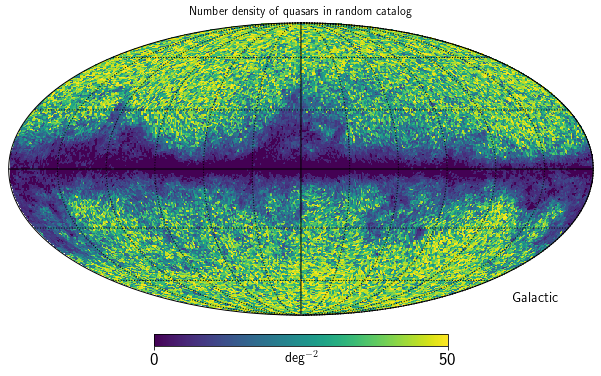

In [175]:
hp.mollview(
    map_nqso_rand/area_per_pixel,
    title=r"Number density of quasars in random catalog",
    unit=r"deg$^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    max=50,
)
hp.graticule()

0.0 180.0 -180.0 180.0


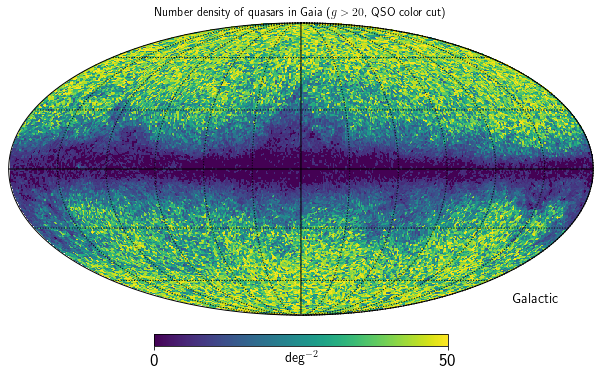

In [176]:
hp.mollview(
    map_nqso/area_per_pixel,
    title=rf"Number density of quasars in Gaia ($g > {gmag_max}$, QSO color cut)",
    unit=r"deg$^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    max=50,
)
hp.graticule()

0.0 180.0 -180.0 180.0


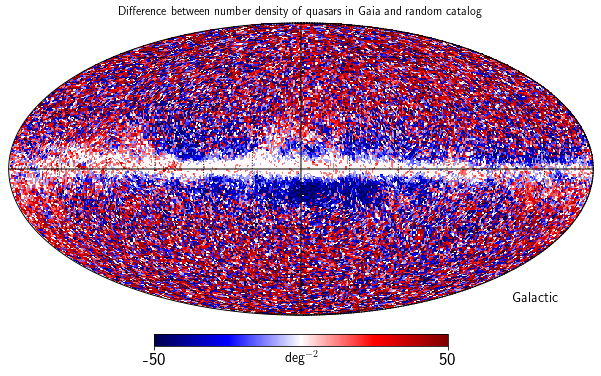

In [118]:
hp.mollview(
    map_nqso/area_per_pixel - map_nqso_rand/area_per_pixel, 
    title=r"Difference between number density of quasars in Gaia and random catalog",
    unit=r"deg$^{-2}$",
    norm="hist",
    cmap='seismic',
    coord=['C', 'G'],
    min=-50,
    max=50,
)
hp.graticule()

In [119]:
ra_sphere, dec_sphere = random_ra_dec_on_sphere(N_rand_target)

Make more catalogs for the denominators for correlation functions

In [120]:
fac_denom = 3

In [121]:
ra_sphere_denom, dec_sphere_denom = random_ra_dec_on_sphere(N_rand_target*fac_denom)

In [122]:
# again for actual random catalog??
ra_rand_denom, dec_rand_denom = generate_random_sfd(N_rand_target*fac_denom, 
                                                    reduction_factor_estimate, params_best_fit)

3322776 2080949 0.6262682166959194


In [123]:
# and again, for random of random
ra_rand_denom2, dec_rand_denom2 = generate_random_sfd(N_rand_target*fac_denom, 
                                                      reduction_factor_estimate, params_best_fit)

3322776 2082755 0.6268117381370276


### Constant redshift sample

In [186]:
def uniform_subsample(zs, z_min, z_max):
    z_bins = np.linspace(z_min, z_max, 100)
    inds = np.digitize(zs, z_bins)
    
    idx_arr = []
    for i in range(1, inds.max()):
        idxs = np.where(inds==i)[0]
        idx_arr.append(idxs)
        
    n_min = np.min([len(idxs) for idxs in idx_arr])
    i_vals_tochoose = []
    for idxs in idx_arr:
        i_vals = np.random.choice(idxs, size=n_min, replace=False)
        i_vals_tochoose.extend(i_vals)
        
    return i_vals_tochoose

In [182]:
len(Y_hat_gaia_photoz), len(tab_gaia[idx_gaia_photoz][idx_good_gaia_photoz])

(651821, 651821)

In [198]:
z_uniform_min, z_uniform_max = 0.5, 2.2
i_uniform = uniform_subsample(Y_hat_gaia_photoz, z_uniform_min, z_uniform_max)
len(i_uniform)

299673

In [199]:
ra_rand_uniform_denom, dec_rand_uniform_denom = generate_random_sfd(len(Y_hat_gaia_photoz[i_uniform])*fac_denom, 
                                                    reduction_factor_estimate, params_best_fit)
len(ra_rand_uniform_denom)

1429419 895735 0.6266427128784492


895735

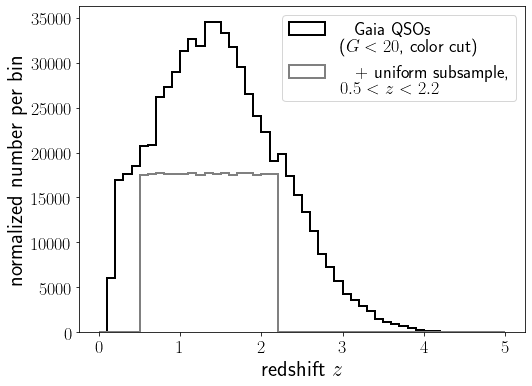

In [226]:
bins = np.linspace(0, 5, 51)

plt.figure(figsize=(8,6))
plt.hist(Y_hat_gaia_photoz, bins=bins, histtype='step', color='k', density=False, 
         label=rf'Gaia QSOs \\($G<{gmag_max}$, color cut)', lw=2)
plt.hist(Y_hat_gaia_photoz[i_uniform], bins=bins, histtype='step', color='grey', density=False, 
         label=rf'+ uniform subsample, \\${z_uniform_min} < z < {z_uniform_max}$', ls='-', lw=2)

plt.xlabel(r'redshift $z$')
plt.ylabel('normalized number per bin')
plt.legend()

## Cumulative distribution

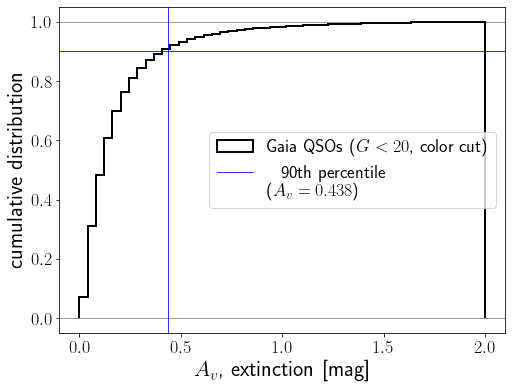

In [124]:
av_bins_cumul = np.linspace(0, 2, 50)

plt.figure(figsize=(8,6))
plt.axhline(0, color='grey', lw=0.8)
plt.axhline(1, color='grey', lw=0.8)
plt.hist(av_gaia_photoz, bins=av_bins_cumul, cumulative=True, histtype='step', density=True, color='k', lw=2,
        label=rf'Gaia QSOs ($G<{gmag_max}$, color cut)')
frac_keep = 0.9
av_thresh = np.quantile(av_gaia_photoz, frac_keep)
plt.axhline(frac_keep, color='b', lw=0.8, label=rf'{int(frac_keep*100)}th percentile \\ ($A_v={av_thresh:.3f}$)')
plt.axvline(av_thresh, color='b', lw=0.8)
plt.ylim(-0.05, 1.05)
plt.xlabel(f'$A_v$, extinction [mag]')
plt.ylabel('cumulative distribution')
plt.legend()

# Investigate number counts

SDSS

In [125]:
pixel_indices_sdss = hp.ang2pix(NSIDE, tab_sdss['RA'], tab_sdss['DEC'], lonlat=True)

In [126]:
# ra is just dummy to count 
ra_grouped_sdss, pixel_indices_sorted_sdss = groupby(tab_sdss['RA'], pixel_indices_sdss)
n_per_pixel_sdss = np.array([len(ras) for ras in ra_grouped_sdss])

In [127]:
map_nqso_sdss = np.zeros(NPIX)
map_nqso_sdss[pixel_indices_sorted_sdss] = n_per_pixel_sdss

In [128]:
n_pixels_with_qsos = len(pixel_indices_sorted_sdss)
area_sdss = n_pixels_with_qsos*hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)
print(area_sdss)

11430.239718366887


NOTE: not doing magnitude cut here! should i be?? 

0.0 180.0 -180.0 180.0


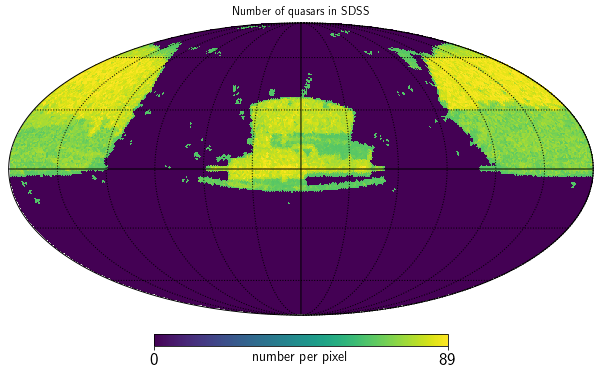

In [129]:
hp.mollview(
    map_nqso_sdss,
    title=r"Number of quasars in SDSS",
    unit=r"number per pixel",
    norm="hist",
    cmap='viridis',
    #coord=['C', 'G']
    #min=-1,
    #max=1,
)
hp.graticule()

In [130]:
g_sdss = tab_sdss['GAIA_G_MAG']
weights_sdss = np.full(len(g_sdss), 1/area_sdss)

All gaia quasars

NOTE: For Gaia area, i include only pixels where there are galaxies, like SDSS??

In [131]:
area_gaia = 4*np.pi*(360/(2*np.pi))**2
print(area_gaia)

41252.96124941928


In [132]:
g_gaia_photoz = tab_gaia['phot_g_mean_mag'][idx_gaia_photoz]
# manually set mag_min, bc its 2.1!
mag_min = 17
mag_max = np.max(g_gaia_photoz)
print(mag_min, mag_max)

bin_width = 0.25
bin_fac = 1/bin_width
mag_bins = np.arange(np.floor(mag_min*bin_fac)/bin_fac, np.ceil(mag_max*bin_fac)/bin_fac+bin_width, bin_width)
print(mag_bins)
weights_gaia_photoz = np.full(len(g_gaia_photoz), 1/area_gaia)

17 19.999998
[17.   17.25 17.5  17.75 18.   18.25 18.5  18.75 19.   19.25 19.5  19.75
 20.  ]


In [133]:
av_max = 0.2
idx_lowext = (av_gaia_photoz < av_max)
idx_highext = (av_gaia_photoz >= av_max)
print(np.sum(idx_lowext)/len(idx_lowext))

0.6878033444873667


NOTE: plotting the SDSS distribution with their matched Gaia G values! is this ok??

In [134]:
print(mags_2slaq)
print(counts_2slaq)

[18.23024954 18.47950117 18.72889478 18.98280819 19.2316457  19.48015192
 19.73398251 19.98257155 20.23097128 20.47940651 20.73296497 20.9810689
 21.22910184 21.48245915 21.73004248]
[0.42883181 0.73361948 1.3352437  1.74643516 2.49379636 3.08169205
 3.88764051 4.98091829 5.87568217 7.0393674  7.88607652 8.17628561
 8.21860686 8.43352174 6.96705642]


In [135]:
mag_small, mag_big = 19, 19.5
idx_mag_in_bins = (mags_2slaq < mag_small)
integral_small = np.sum(counts_2slaq[idx_mag_in_bins])
idx_mag_in_bins = (mags_2slaq < mag_big)
integral_big = np.sum(counts_2slaq[idx_mag_in_bins])
print(f'Integrated flux to {mag_small}/Integrated flux to {mag_big}:', integral_small/integral_big)
print('At mean number density of qsos at A_v=0:', integral_small/integral_big*ndens_qso_at_av0)

Integrated flux to 19/Integrated flux to 19.5: 0.432209268167603
At mean number density of qsos at A_v=0: 11.327430136624463


fix this to be proper area! for extinction divide, should be the area of the mean map where there is that level of extinction. for gaia i should do all-sky as ive done, and my sdss method fine too

(array([  36., 1987., 3834., 3280., 2906., 2518., 2208., 2007., 1744.,
        1640., 1291., 1177., 1038.,  999.,  869.,  769.,  727.,  657.,
         502.,  487.,  491.,  431.,  412.,  416.,  366.,  308.,  320.,
         293.,  279.,  269.,  240.,  207.,  228.,  221.,  205.,  175.,
         168.,  158.,  163.,  165.,  161.,  141.,  132.,  113.,  132.,
         124.,  119.,  129.,  121.]),
 array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
        0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
        0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
        0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
        0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
        0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
        0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795

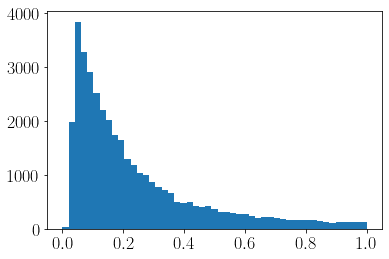

In [136]:
plt.hist(map_av_rand, bins=av_bins)

In [137]:
print(NPIX)

46128


In [138]:
n_pix_lowext = np.sum(map_av_rand < av_max)
area_lowext = n_pix_lowext*area_per_pixel
n_pix_highext = np.sum(map_av_rand >= av_max)
area_highext = n_pix_highext*area_per_pixel
print(area_lowext, area_highext)
print(area_lowext+area_highext, area_gaia)

19547.042447722793 21705.91880169648
41252.96124941927 41252.96124941928


In [139]:
weights_lowext = np.full(np.sum(idx_lowext), 1/area_lowext)
weights_highext = np.full(np.sum(idx_highext), 1/area_highext)

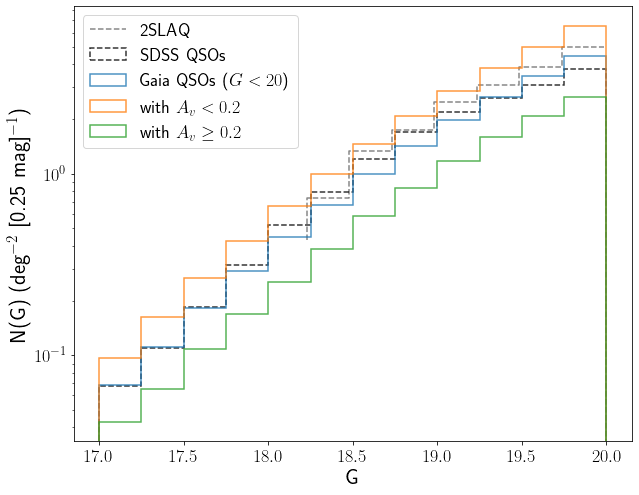

In [141]:
alpha=0.8
lw=1.5
histtype='step'
plt.figure(figsize=(10,8))
idx_mag_in_bins = (mags_2slaq < np.max(mag_bins)) & (mags_2slaq > np.min(mag_bins))
plt.step(mags_2slaq[idx_mag_in_bins], counts_2slaq[idx_mag_in_bins], alpha=alpha, 
         label='2SLAQ', color='dimgrey', where='pre', ls='--')
plt.hist(g_sdss, bins=mag_bins, weights=weights_sdss, alpha=alpha, histtype=histtype, color='k',
         label=r'SDSS QSOs', lw=lw, ls='--')
plt.hist(g_gaia_photoz, bins=mag_bins, weights=weights_gaia_photoz, alpha=alpha, histtype=histtype, 
         label=rf'Gaia QSOs ($G<{gmag_max}$)', lw=lw)
plt.hist(g_gaia_photoz[idx_lowext], bins=mag_bins, weights=weights_lowext, alpha=alpha, histtype=histtype, 
         label=rf'with $A_v < {av_max}$', lw=lw)
plt.hist(g_gaia_photoz[idx_highext], bins=mag_bins, weights=weights_highext, alpha=alpha, histtype=histtype, 
         label=rf'with $A_v \ge {av_max}$', lw=lw)
plt.xlabel('G')
plt.ylabel(r'N(G) (deg$^{-2}$ [0.25 mag]$^{-1}$)')

plt.yscale('log')
plt.legend(loc='upper left')

# Correlation function attempts

In [248]:
from astropy.table import Table
from astropy.io import fits
import astropy.cosmology
from astropy import units as u
from astropy.coordinates import SkyCoord

In [249]:
from Corrfunc.theory import DD
from Corrfunc.theory import xi
from Corrfunc.mocks.DDrppi_mocks import DDrppi_mocks
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.utils import convert_rp_pi_counts_to_wp

In [250]:
def compute_xi(r_edges, x, y, z, x_rand, y_rand, z_rand,
               return_full_results=False):
    
    nthreads = 4
    
    start = time.time()
    autocorr=1
    res_dd = DD(autocorr, nthreads, r_edges, x, y, z, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    start = time.time()
    autocorr=0
    res_dr = DD(autocorr, nthreads, r_edges, x, y, z,
                X2=x_rand, Y2=y_rand, Z2=z_rand, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')

    start = time.time()
    autocorr=1
    res_rr = DD(autocorr, nthreads, r_edges, x_rand, y_rand, z_rand, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    print()
    
    N = len(x)
    N_rand = len(x_rand)
    xi = convert_3d_counts_to_cf(N, N, N_rand, N_rand,
                                     res_dd, res_dr,
                                     res_dr, res_rr)
    
    if return_full_results:
        return xi, res_dd, res_dr, res_rr
    
    return xi

In [251]:
def compute_wtheta(theta_edges, ra, dec, ra_rand, dec_rand,
                   return_full_results=False):
    
    nthreads = 4
    
    autocorr = 1
    start = time.time()
    DD_theta = DDtheta_mocks(autocorr, nthreads, theta_edges, ra, dec)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    autocorr = 0
    start = time.time()
    DR_theta = DDtheta_mocks(autocorr, nthreads, theta_edges,
                               ra, dec,
                               RA2=ra_rand, DEC2=dec_rand)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    start = time.time()
    autocorr = 1
    RR_theta = DDtheta_mocks(autocorr, nthreads, theta_edges, ra_rand, dec_rand)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    N = len(ra)
    N_rand = len(ra_rand)
    wtheta = convert_3d_counts_to_cf(N, N, N_rand, N_rand,
                                 DD_theta, DR_theta,
                                 DR_theta, RR_theta)
    
    if return_full_results:
        return wtheta, DD_theta, DR_theta, RR_theta
    
    return wtheta

In [252]:
def radec_to_cartesian(r, ra, dec):
    
    theta = ra * np.pi/180
    phi = (90 - dec) * np.pi/180

    x, y, z = spherical_to_cartesian(r, theta, phi)
    return np.array([x, y, z])

In [100]:
def spherical_to_cartesian(r, theta, phi):
    x       =  r*np.cos(theta)*np.sin(phi)
    y       =  r*np.sin(theta)*np.sin(phi)
    z       =  r*np.cos(phi)
    return np.array([x, y, z])

In [101]:
def generate_shuffled_random(factor, ra, dec, redshift, distance, rng):
    N = len(ra)
    N_rand = factor*N

    i_vals = np.arange(N)

    i_radec_rand = rng.choice(i_vals, size=N_rand, replace=True)
    ra_rand = ra[i_radec_rand]
    dec_rand = dec[i_radec_rand]

    i_redshift_rand = rng.choice(i_vals, size=N_rand, replace=True)
    redshift_rand = redshift[i_redshift_rand]
    dist_rand = distance[i_redshift_rand]
    
    x_rand, y_rand, z_rand = radec_to_cartesian(dist_rand, ra_rand, dec_rand)
    
    rand = Table([ra_rand, dec_rand, redshift_rand, dist_rand,
                      x_rand, y_rand, z_rand], 
              names=('ra', 'dec', 'redshift', 'distance', 'x', 'y', 'z'), 
              meta={'name': 'random_shuffle'})
    return rand

In [102]:
cosmo = astropy.cosmology.Planck15
dist = (cosmo.comoving_distance(Y_hat_gaia_photoz)*cosmo.h).value # convert to Mpc/h

In [150]:
ra = tab_gaia['ra'][idx_gaia_photoz][idx_good_gaia_photoz]
dec = tab_gaia['ra'][idx_gaia_photoz][idx_good_gaia_photoz]

In [151]:
x, y, z = radec_to_cartesian(dist, ra, dec)

Make random catalog

In [152]:
from numpy.random import default_rng
rng = default_rng(seed=42)

In [153]:
factor = 1
rand = generate_shuffled_random(factor, ra, dec, Y_hat_gaia_photoz, dist, rng)
len(rand)

651821

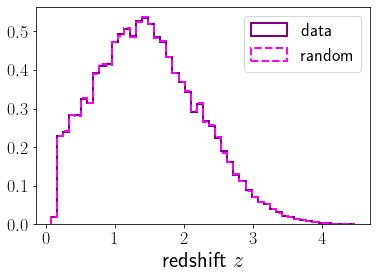

In [154]:
plt.hist(Y_hat_gaia_photoz, bins=50, histtype='step', color='purple', density=True, label='data', lw=2)
plt.hist(rand['redshift'], bins=50, histtype='step', color='magenta', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

In [155]:
nthreads = 4
rmin, rmax = 20, 180
bin_size = 8
r_edges = np.arange(rmin, rmax+bin_size, bin_size)
r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])

In [156]:
xi, res_dd, res_dr, res_rr = compute_xi(r_edges, x, y, z, 
                                        rand['x'], rand['y'], rand['z'],
                                        return_full_results=True)

[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?


Time: 1.7408 s
Time: 3.8147 s
Time: 1.8776 s



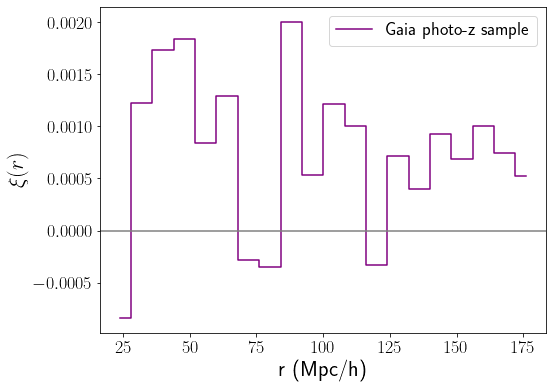

In [157]:
plt.figure(figsize=(8,6))
plt.step(r_avg, xi, where='mid', color='purple', label='Gaia photo-z sample')

plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

## Angular

Check BAO scale 

In [158]:
z_mean = np.mean(Y_hat_gaia_photoz)
print(z_mean)

1.4883244482563471


In [159]:
arcsec_per_kpc = cosmo.arcsec_per_kpc_comoving(z_mean)
arcsec_per_Mpc = arcsec_per_kpc.to(u.arcsec/u.Mpc)
deg_per_Mpc = arcsec_per_kpc.to(u.deg/u.Mpc)
print(arcsec_per_kpc, '=', arcsec_per_Mpc, '=', deg_per_Mpc)

0.04627898594622876 arcsec / kpc = 46.278985946228765 arcsec / Mpc = 0.012855273873952435 deg / Mpc


In [160]:
r_bao_Mpc = 105 * u.Mpc / cosmo.h # divide out little h to get Mpc
bao_deg = r_bao_Mpc*deg_per_Mpc
print(f'BAO length scale at z={z_mean:.3f}: {bao_deg:.3f}')

BAO length scale at z=1.488: 1.993 deg


Linear

In [202]:
nbins = 40
theta_edges = np.linspace(0.5, 4, nbins + 1)
theta_avg = 10**(0.5*(np.log10(theta_edges[:-1]) + np.log10(theta_edges[1:])))
print(theta_edges)

[0.5    0.5875 0.675  0.7625 0.85   0.9375 1.025  1.1125 1.2    1.2875
 1.375  1.4625 1.55   1.6375 1.725  1.8125 1.9    1.9875 2.075  2.1625
 2.25   2.3375 2.425  2.5125 2.6    2.6875 2.775  2.8625 2.95   3.0375
 3.125  3.2125 3.3    3.3875 3.475  3.5625 3.65   3.7375 3.825  3.9125
 4.    ]


In [203]:
wtheta_gaia_photoz, dd_gaia_photoz, _, _, = compute_wtheta(theta_edges, 
                                                tab_gaia['ra'][idx_gaia_photoz],  tab_gaia['dec'][idx_gaia_photoz], 
                                                ra_rand_denom, dec_rand_denom, return_full_results=True)

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 2.9185 s
Time: 16.4481 s
Time: 24.4562 s


In [205]:
ra_uniform =  tab_gaia['ra'][idx_gaia_photoz][idx_good_gaia_photoz][i_uniform]
dec_uniform = tab_gaia['dec'][idx_gaia_photoz][idx_good_gaia_photoz][i_uniform] 
wtheta_gaia_photoz_uniform, dd_gaia_photoz_uniform, _, _, = compute_wtheta(theta_edges, 
                                                ra_uniform, dec_uniform,
                                                ra_rand_uniform_denom, dec_rand_uniform_denom, 
                                                return_full_results=True)

Time: 0.6970 s
Time: 3.0991 s
Time: 4.2222 s


In [206]:
wtheta_sphere, dd_sphere, _, _, = compute_wtheta(theta_edges, ra_sphere,  dec_sphere, 
                        ra_sphere_denom, dec_sphere_denom, return_full_results=True)

Time: 2.4974 s
Time: 14.3076 s
Time: 20.9965 s


In [207]:
wtheta_rand, dd_rand, _, _, = compute_wtheta(theta_edges, ra_rand,  dec_rand, 
                                    ra_rand_denom2, dec_rand_denom2, return_full_results=True)

Time: 3.2777 s
Time: 18.3059 s
Time: 25.4492 s


In [208]:
wtheta_sphere, dd_sphere, _, _, = compute_wtheta(theta_edges, ra_sphere,  dec_sphere, 
                        ra_sphere_denom, dec_sphere_denom, return_full_results=True)

Time: 2.4713 s
Time: 14.3813 s
Time: 21.0596 s


In [209]:
print(len(tab_gaia['ra'][idx_gaia_photoz]), len(ra_rand), len(ra_sphere))

696609 694015 696609


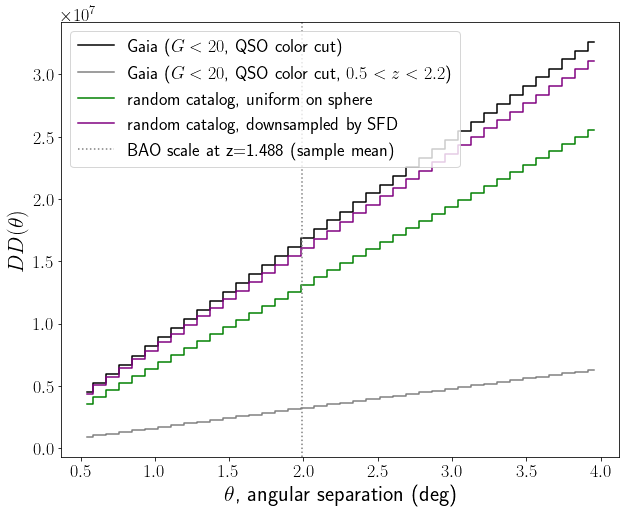

In [210]:
plt.figure(figsize=(10,8))
plt.step(theta_avg, dd_gaia_photoz['npairs'], where='mid', label=rf'Gaia ($G<{gmag_max}$, QSO color cut)', color='k')
plt.step(theta_avg, dd_gaia_photoz_uniform['npairs'], where='mid', 
         label=rf'Gaia ($G<{gmag_max}$, QSO color cut, ${z_uniform_min} < z < {z_uniform_max}$)', color='grey')
plt.step(theta_avg, dd_sphere['npairs'], where='mid', label='random catalog, uniform on sphere', color='g')
plt.step(theta_avg, dd_rand['npairs'], where='mid', label='random catalog, downsampled by SFD', color='purple')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$DD(\theta)$')
plt.axvline(bao_deg.value, color='grey', ls=':', label=rf'BAO scale at z={z_mean:.3f} (sample mean)')
plt.legend()

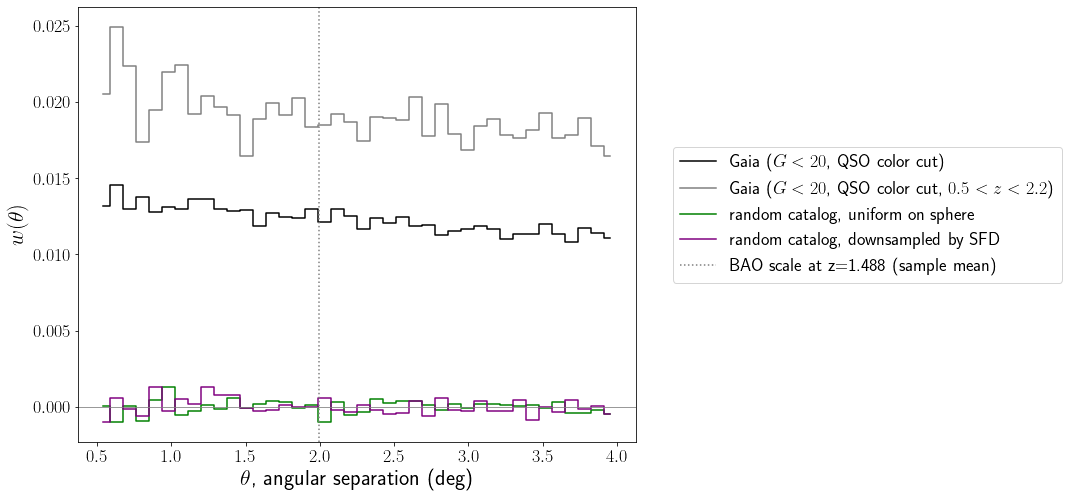

In [224]:
plt.figure(figsize=(10,8))
plt.step(theta_avg, wtheta_gaia_photoz, where='mid', label=rf'Gaia ($G<{gmag_max}$, QSO color cut)', color='k')
plt.step(theta_avg, wtheta_gaia_photoz_uniform, where='mid', 
         label=rf'Gaia ($G<{gmag_max}$, QSO color cut, ${z_uniform_min} < z < {z_uniform_max}$)', color='grey')
plt.step(theta_avg, wtheta_sphere, where='mid', label='random catalog, uniform on sphere', color='g')
plt.step(theta_avg, wtheta_rand, where='mid', label='random catalog, downsampled by SFD', color='purple')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.axhline(0, color='grey', lw=0.8)
plt.axvline(bao_deg.value, color='grey', ls=':', label=rf'BAO scale at z={z_mean:.3f} (sample mean)')
plt.legend(bbox_to_anchor=(1.05, 0.7))

Log

In [112]:
nbins = 30
theta_edges_log = np.logspace(-1, 1, nbins + 1)
theta_avg_log = 10**(0.5*(np.log10(theta_edges_log[:-1]) + np.log10(theta_edges_log[1:])))
print(theta_edges_log)

[ 0.1         0.11659144  0.13593564  0.15848932  0.18478498  0.21544347
  0.25118864  0.29286446  0.34145489  0.39810717  0.46415888  0.54116953
  0.63095734  0.73564225  0.8576959   1.          1.1659144   1.35935639
  1.58489319  1.8478498   2.15443469  2.51188643  2.92864456  3.41454887
  3.98107171  4.64158883  5.41169527  6.30957344  7.35642254  8.57695899
 10.        ]


In [213]:
wtheta_gaia_photoz_log, dd_gaia_photoz_log, _, _, = compute_wtheta(theta_edges_log, 
                                                tab_gaia['ra'][idx_gaia_photoz],  tab_gaia['dec'][idx_gaia_photoz], 
                                                ra_rand_denom, dec_rand_denom, return_full_results=True)

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 12.6111 s
Time: 71.1963 s
Time: 100.6083 s


In [214]:
wtheta_gaia_photoz_uniform_log, dd_gaia_photoz_uniform_log, _, _, = compute_wtheta(theta_edges_log, 
                                                ra_uniform, dec_uniform, 
                                                ra_rand_uniform_denom, dec_rand_uniform_denom, 
                                                return_full_results=True)

Time: 2.4143 s
Time: 14.7064 s
Time: 20.5748 s


In [215]:
wtheta_rand_log, dd_rand_log, _, _, = compute_wtheta(theta_edges_log, ra_rand,  dec_rand, 
                                    ra_rand_denom2, dec_rand_denom2, return_full_results=True)

Time: 11.7252 s
Time: 71.4036 s
Time: 113.7537 s


In [216]:
wtheta_sphere_log, dd_sphere_log, _, _, = compute_wtheta(theta_edges_log, ra_sphere,  dec_sphere, 
                        ra_sphere_denom, dec_sphere_denom, return_full_results=True)

Time: 9.6247 s
Time: 64.7685 s
Time: 96.0565 s


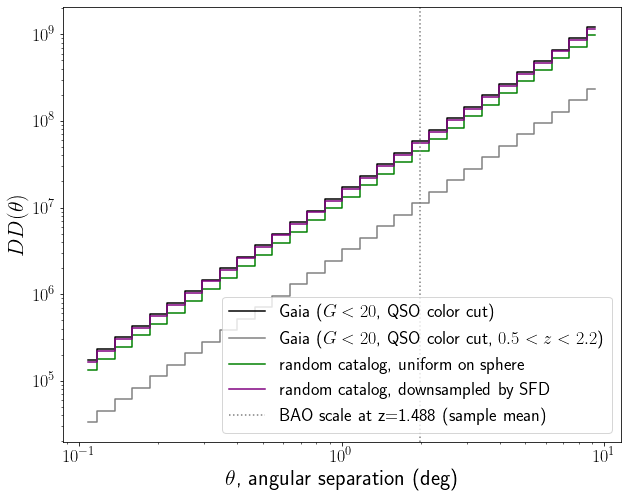

In [217]:
plt.figure(figsize=(10,8))
plt.step(theta_avg_log, dd_gaia_photoz_log['npairs'], where='mid', 
         label=rf'Gaia ($G<{gmag_max}$, QSO color cut)', color='k')
plt.step(theta_avg_log, dd_gaia_photoz_uniform_log['npairs'], where='mid', 
         label=rf'Gaia ($G<{gmag_max}$, QSO color cut, ${z_uniform_min} < z < {z_uniform_max}$)', color='grey')
plt.step(theta_avg_log, dd_sphere_log['npairs'], where='mid', label='random catalog, uniform on sphere', color='g')
plt.step(theta_avg_log, dd_rand_log['npairs'], where='mid', label='random catalog, downsampled by SFD', color='purple')
plt.axvline(bao_deg.value, color='grey', ls=':', label=rf'BAO scale at z={z_mean:.3f} (sample mean)')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$DD(\theta)$')
plt.legend()
plt.xscale('log')
plt.yscale('log')

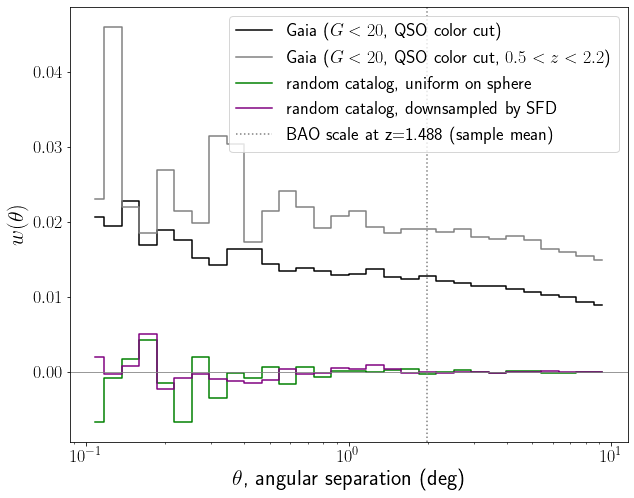

In [218]:
plt.figure(figsize=(10,8))
plt.step(theta_avg_log, wtheta_gaia_photoz_log, where='mid', label=rf'Gaia ($G<{gmag_max}$, QSO color cut)', color='k')
plt.step(theta_avg_log, wtheta_gaia_photoz_uniform_log, where='mid', 
         label=rf'Gaia ($G<{gmag_max}$, QSO color cut, ${z_uniform_min} < z < {z_uniform_max}$)', color='grey')
plt.step(theta_avg_log, wtheta_sphere_log, where='mid', label='random catalog, uniform on sphere', color='g')
plt.step(theta_avg_log, wtheta_rand_log, where='mid', label='random catalog, downsampled by SFD', color='purple')
plt.axvline(bao_deg.value, color='grey', ls=':', label=rf'BAO scale at z={z_mean:.3f} (sample mean)')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.axhline(0, color='grey', lw=0.8)

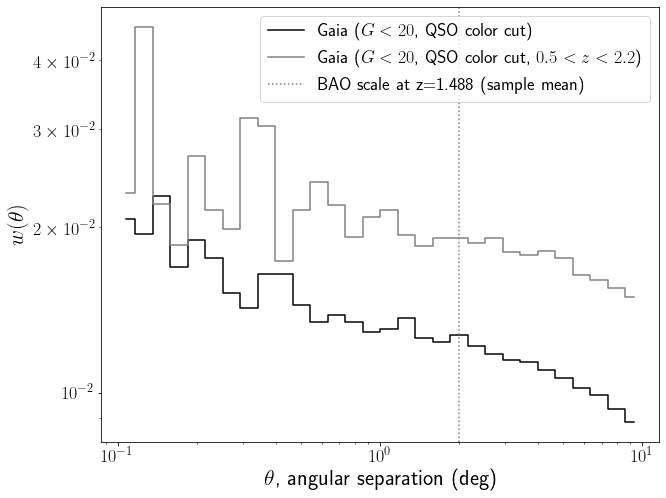

In [219]:
plt.figure(figsize=(10,8))
plt.step(theta_avg_log, wtheta_gaia_photoz_log, where='mid', label=rf'Gaia ($G<{gmag_max}$, QSO color cut)', color='k')
plt.step(theta_avg_log, wtheta_gaia_photoz_uniform_log, where='mid', 
         label=rf'Gaia ($G<{gmag_max}$, QSO color cut, ${z_uniform_min} < z < {z_uniform_max}$)', color='grey')
plt.axvline(bao_deg.value, color='grey', ls=':', label=rf'BAO scale at z={z_mean:.3f} (sample mean)')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.axhline(0, color='grey', lw=0.8)

## Effect of magnitude cut on w(theta), angular correlation function

In [103]:
nbins = 20
theta_edges_log = np.logspace(-1, 1, nbins + 1)
theta_avg_log = 10**(0.5*(np.log10(theta_edges_log[:-1]) + np.log10(theta_edges_log[1:])))
print(theta_edges_log)

[ 0.1         0.12589254  0.15848932  0.19952623  0.25118864  0.31622777
  0.39810717  0.50118723  0.63095734  0.79432823  1.          1.25892541
  1.58489319  1.99526231  2.51188643  3.16227766  3.98107171  5.01187234
  6.30957344  7.94328235 10.        ]


In [104]:
wthetas_gmaglim_log = []
n_sources_gmaglim = []

tab_gaia_photoz = tab_gaia[idx_gaia_photoz]
print(len(tab_gaia_photoz))
mag_maxs = [18, 18.5, 19, 19.5, 20]
#mag_maxs = [18]
for i in range(len(mag_maxs)):
    idx_gmaglim = (tab_gaia_photoz['phot_g_mean_mag'] < mag_maxs[i])  
    ra_gmaglim, dec_gmaglim = tab_gaia_photoz['ra'][idx_gmaglim], tab_gaia_photoz['dec'][idx_gmaglim]
    n_sources_gmaglim.append(len(ra_gmaglim))
    print(len(ra_gmaglim))
    
    fac_denom = 3
    N_rand_target = fac_denom*len(ra_gmaglim)
    ra_rand_gmaglim_denom, dec_rand_gmaglim_denom = generate_random_sfd(N_rand_target*fac_denom, 
                                                        reduction_factor_estimate, params_best_fit)
    
    wtheta_gmaglim_log, dd_gmaglim_log, _, _, = compute_wtheta(theta_edges_log, 
                                                ra_gmaglim, dec_gmaglim,
                                                ra_rand_gmaglim_denom, dec_rand_gmaglim_denom,
                                                return_full_results=True)
    
    wthetas_gmaglim_log.append(wtheta_gmaglim_log)

696609
31752


[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 0.0808 s
Time: 0.3990 s
Time: 1.2906 s
78044
Time: 0.1597 s
Time: 2.0606 s
Time: 8.3235 s
177968
Time: 0.6166 s
Time: 11.3005 s
Time: 49.7114 s
369016
Time: 2.5798 s
Time: 48.7878 s
Time: 204.8765 s
696609
Time: 9.1030 s
Time: 165.6614 s
Time: 737.9132 s


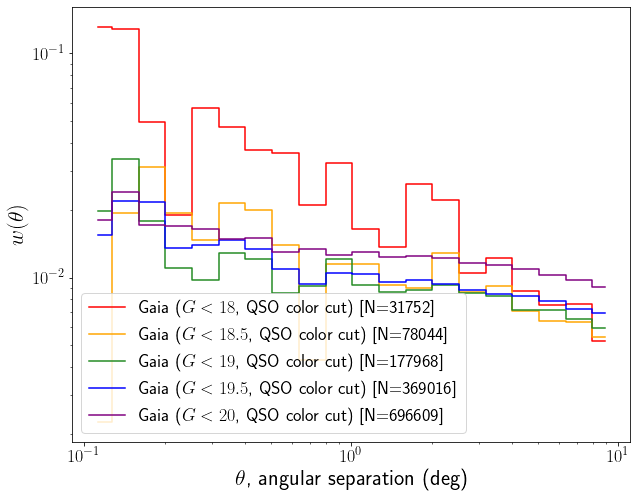

In [105]:
plt.figure(figsize=(10,8))

colors = ['red', 'orange', 'forestgreen', 'blue', 'purple']
for i in range(len(mag_maxs)):
    wtheta_gmaglim_log = wthetas_gmaglim_log[i]
    plt.step(theta_avg_log, wtheta_gmaglim_log, where='mid', 
             label=rf'Gaia ($G<{mag_maxs[i]}$, QSO color cut) [N={n_sources_gmaglim[i]}]', color=colors[i])
#plt.axvline(bao_deg.value, color='grey', ls=':', label=rf'BAO scale at z={z_mean:.3f} (sample mean)')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.axhline(0, color='grey', lw=0.8)

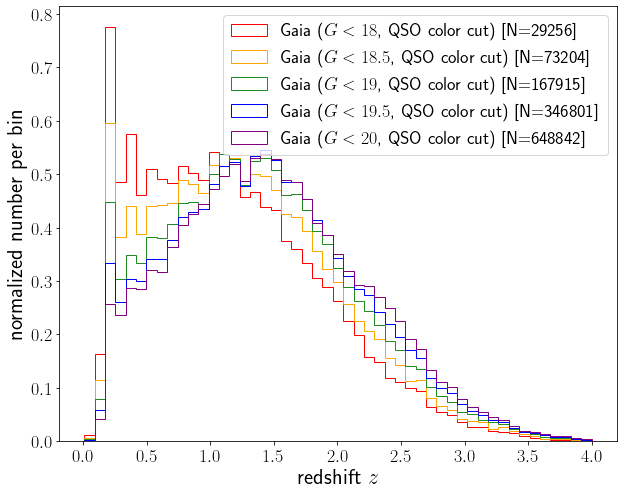

In [266]:
z_bins = np.linspace(0.01, 4, 50)
n_sources_gmaglim_zbins = []

tab_gaia_photoz = tab_gaia[idx_gaia_photoz]

mag_maxs_zbins = [18, 18.5, 19, 19.5, 20]
colors = ['red', 'orange', 'forestgreen', 'blue', 'purple']

#mag_maxs = [18]
plt.figure(figsize=(10,8))
for i in range(len(mag_maxs)):
    idx_gmaglim = (tab_gaia_photoz['phot_g_mean_mag'][idx_good_gaia_photoz] < mag_maxs_zbins[i])  
    n_sources_gmaglim_zbins.append(np.sum(idx_gmaglim))

    redshift_phot_maglim = Y_hat_gaia_photoz[idx_gmaglim]
    plt.hist(redshift_phot_maglim, bins=z_bins, color=colors[i], histtype='step', density=True,
             label=rf'Gaia ($G<{mag_maxs_zbins[i]}$, QSO color cut) [N={n_sources_gmaglim_zbins[i]}]')
    
plt.xlabel(r'redshift $z$')
plt.ylabel('normalized number per bin')
plt.legend()


[19.  19.2 19.4 19.6 19.8 20. ]


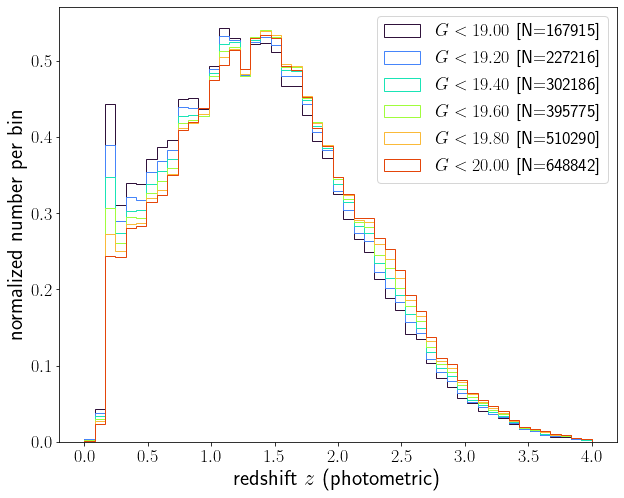

In [267]:
z_bins = np.linspace(0, 4, 50)
n_sources_gmaglim_zbins = []

mag_min_zbins, mag_max_zbins = 19.0, 20.2
mag_maxs_zbins = np.arange(mag_min_zbins, mag_max_zbins, 0.2)
norm = matplotlib.colors.Normalize(vmin=mag_min_zbins, vmax=mag_max_zbins)

cmap = matplotlib.cm.get_cmap('turbo')


print(mag_maxs_zbins)
#mag_maxs = [18]
plt.figure(figsize=(10,8))
for i in range(len(mag_maxs_zbins)):
    idx_gmaglim = (tab_gaia_photoz['phot_g_mean_mag'][idx_good_gaia_photoz] < mag_maxs_zbins[i])  
    n_sources_gmaglim_zbins.append(np.sum(idx_gmaglim))

    redshift_phot_maglim = Y_hat_gaia_photoz[idx_gmaglim]
    color = cmap(norm(mag_maxs_zbins[i]))

    plt.hist(redshift_phot_maglim, bins=z_bins, color=color, histtype='step', density=True,
             label=rf'$G<{mag_maxs_zbins[i]:.2f}$ [N={n_sources_gmaglim_zbins[i]}]')
    
plt.xlabel(r'redshift $z$ (photometric)')
plt.ylabel('normalized number per bin')
plt.legend()


[19.  19.2 19.4 19.6 19.8 20.  20.2 20.4 20.6 20.8]


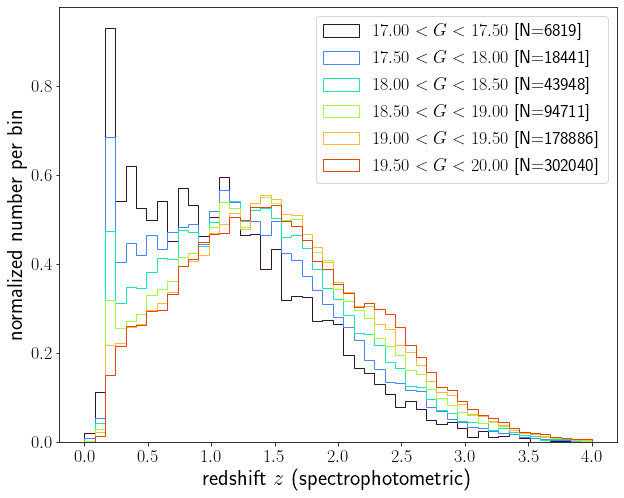

In [282]:
z_bins = np.linspace(0, 4, 50)
n_sources_gmagslices_zbins = []

mag_min_zbins, mag_max_zbins = 17.0, 20.5
mag_gmagslices_zbins = np.arange(mag_min_zbins, mag_max_zbins, 0.5)

norm = matplotlib.colors.Normalize(vmin=mag_gmagslices_zbins[0], vmax=mag_gmagslices_zbins[-1])
cmap = matplotlib.cm.get_cmap('turbo')

print(mag_maxs_zbins)
plt.figure(figsize=(10,8))
for i in range(len(mag_gmagslices_zbins)-1):
    idx_gmagslices = (tab_gaia_photoz['phot_g_mean_mag'][idx_good_gaia_photoz] > mag_gmagslices_zbins[i]) & \
                     (tab_gaia_photoz['phot_g_mean_mag'][idx_good_gaia_photoz] < mag_gmagslices_zbins[i+1])  
    n_sources_gmagslices_zbins.append(np.sum(idx_gmagslices))

    redshift_phot_gslices = Y_hat_gaia_photoz[idx_gmagslices]
    color = cmap(norm(mag_gmagslices_zbins[i]))

    plt.hist(redshift_phot_gslices, bins=z_bins, color=color, histtype='step', density=True,
             label=rf'${mag_gmagslices_zbins[i]:.2f}<G<{mag_gmagslices_zbins[i+1]:.2f}$ [N={n_sources_gmagslices_zbins[i]}]')
    
plt.xlabel(r'redshift $z$ (spectrophotometric)')
plt.ylabel('normalized number per bin')
plt.legend()

[19.  19.2 19.4 19.6 19.8 20.  20.2 20.4 20.6 20.8]


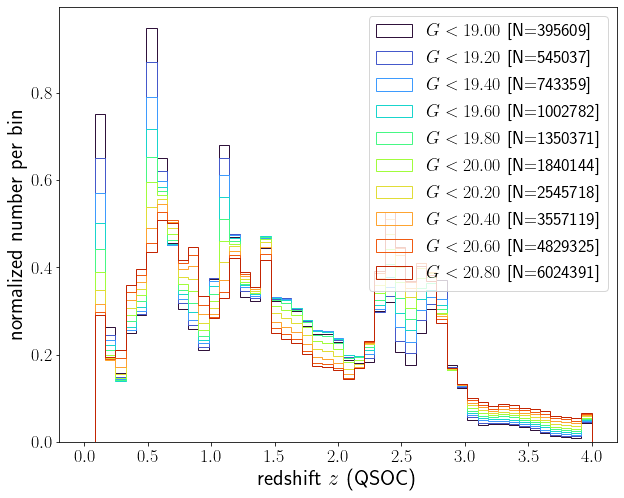

In [269]:
z_bins = np.linspace(0, 4, 50)
n_sources_gmaglim_zbins = []

mag_min_zbins, mag_max_zbins = 19.0, 21.0
mag_maxs_zbins = np.arange(mag_min_zbins, mag_max_zbins, 0.2)
norm = matplotlib.colors.Normalize(vmin=mag_min_zbins, vmax=mag_max_zbins)

cmap = matplotlib.cm.get_cmap('turbo')

print(mag_maxs_zbins)
#mag_maxs = [18]
plt.figure(figsize=(10,8))
for i in range(len(mag_maxs_zbins)):
    idx_gmaglim = (tab_gaia['phot_g_mean_mag'] < mag_maxs_zbins[i])  
    n_sources_gmaglim_zbins.append(np.sum(idx_gmaglim))

    redshift_qsoc_maglim = tab_gaia['redshift_qsoc'][idx_gmaglim]
    color = cmap(norm(mag_maxs_zbins[i]))

    plt.hist(redshift_qsoc_maglim, bins=z_bins, color=color, histtype='step', density=True,
             label=rf'$G<{mag_maxs_zbins[i]:.2f}$ [N={n_sources_gmaglim_zbins[i]}]')
    
plt.xlabel(r'redshift $z$ (QSOC)')
plt.ylabel('normalized number per bin')
plt.legend()
